# Frequency domain

**In this lecture, we will learn**
- what Fourier Series, Fourier Transform, Discrete Time Fourier Transform and Discrete Fourier Transform are and how they are related,
- how to generalize DFT to 2D,
- what 2D spectrum of an image is and how to plot it,
- how to properly use 2D DFT for image filtering,
- how to restore degraded image using inverse and Wiener filters,
- how JPEG image compression works.

**The lecture is based on**
- Chapter 4 "Filtering in the Frequency Domain" of  
  [\[Gonzalez18\] Rafael C. Gonzalez, Richard E. Woods. *Digital Image Processing (4th edition)*](https://www.imageprocessingplace.com/)
- Chapter "Fourier Analysis" of Youtube series  
  [Steve Brunton: *Data-Driven Science and Engineering*](https://www.youtube.com/playlist?list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC)

In [1]:
import os
from typing import Union

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import skimage

In [2]:
plt.rcParams['figure.constrained_layout.use'] = True
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Basics

## Sine and cosine functions

**The cosine function is**
$$
y = a \cdot \cos(\omega \cdot t - \varphi)
$$
where
- $t$ is the input variable, e.g. time that goes from $-\infty$ to $+\infty$,
- $\omega$ is the *angular frequency*, i.e. the number of oscillations over the interval $2\pi$,
- $\varphi$ is the *phase*,
- $a$ is the *amplitude*.

The function is **periodic** with period
$$
T = \frac{2\pi}{\omega}
$$
meaning it will produce the same sequence of values with length $T$, i.e.
$$
\cos(\omega \cdot t - \varphi) = \cos(\omega \cdot t - \varphi + k \cdot T)
$$

**The sine function can be thought of as cosine shifted by $-\pi/2$**
$$
y = a \cdot \sin(\omega \cdot t - \varphi) = \cos(\omega \cdot t - \varphi - \frac{\pi}{2})
$$

In [3]:
@ipywidgets.interact(
    ampl = (0., 2., 0.2),
    omega = (0., 5., 0.5),
    phase = (-np.pi/2., np.pi/2, np.pi/10)
)
def sine_and_cosine(
    ampl: float = 1.,
    omega: float = 1.,
    phase: float = 0.
) -> None:
    with sns.axes_style(style='darkgrid'):
        fig, ax = plt.subplots()
        t = np.linspace(-2., 2. * np.pi, 200)
        ax.plot(t, ampl * np.sin(omega * t - phase), label='sin');
        ax.plot(t, ampl * np.cos(omega * t - phase), label='cos');
        ax.set_ylim(-2., 2.)
        ax.legend(loc='lower left');
        ax.set_title(rf"${ampl} \cdot \sin/\cos({omega} \cdot t {'-' if phase >= 0 else '+'} {abs(phase):.3f})$")
        ax.set_xlabel('$t$')

interactive(children=(FloatSlider(value=1.0, description='ampl', max=2.0, step=0.2), FloatSlider(value=1.0, de…

## Complex numbers and Euler's notation

- Complex numbers $\mathbb{C}$ have *real* and *imaginary* components
  $$
  z = a + \text{i} \cdot b
  $$
  where
  - $a = \text{Re}(z)$ is the *real part*,
  - $b = \text{Im}(z)$ is the *imaginary part*,
  - $\text{i}$ is the *imaginary unit* defined such that $\text{i}^2 = -1$ or as $\text{i} = \sqrt{-1}$.
- Complex numbers can be viewed geometrically as points $(a, b)$ on a plane called the *complex plane*.

<figure class="image">
  <img src="../figures/frequency_domain-complex_number.svg" alt="" style="width: 6.4in; background: white"/>
  <figcaption>
    A complex number.
    Source: <a href=https://en.wikipedia.org/wiki/Complex_number>Wikipedia</a>
  </figcaption>
</figure>

- The **Euler's formula** says that complex numbers along a *unit circle* may be written as
  $$
  z = e^{\text{i}\cdot \theta} = \cos(\theta) + \text{i}\cdot\sin(\theta)
  $$
  with
  - $\text{Re}(z) = \cos(\theta)$,
  - $\text{Im}(z) = \sin(\theta)$,
  - the *magnitude* of the complex number $|z| = 1$
- Chaning the magnitude does not impact the phase and vice versa, i.e.
  $$
  |a \cdot e^{\text{i}\cdot \theta}| = a \cdot |e^{\text{i}\cdot \theta}| = a
  $$
  and
  $$
  e^{\text{i}\cdot (\theta + \varphi)} = e^{\text{i}\cdot \theta} \cdot e^{\text{i}\cdot \varphi}
  $$

# Fourier transform

- Orignally developed for solving partial differential equations, in particular heat equation.
- Fourier transform enabled calculation of approximate solutions.

## Fourier series

- Let's assume a *real continuous periodic* function $f(t)$ with period $T$, defined over the interval $t \in [-T/2, +T/2]$.
- Any such function can be expressed as an infinite appropriately weighted sum of sines and cosines.
  $$
  f(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty}{ a_k \cdot \cos\left(k \cdot \frac{2\pi}{T}\cdot t\right) + b_k \cdot \sin\left(k \cdot \frac{2\pi}{T}\cdot t\right) }
  $$
  where
  - $\omega = 2\pi/T$ is the fundamental angular frequency,
  - $a_k, b_k$ are Fourier coefficients.
- This sum is known as the **Fourier series**.
- Notice that the angular frequencies of the sine and cosine functions are integer multiples $k \cdot w$ of the fundamental frequency $w$, so called *harmonics*.
- The process of finding out the values of $a_k, b_k$ is commonly referred to as the **Fourier analysis**
  $$
  a_k = \frac{2}{T} \cdot \int_{-T/2}^{+T/2}{ f(t) \cdot \cos\left(k \cdot \frac{2\pi}{T}\cdot t\right) \cdot \text{d}t}
  \qquad
  b_k = \frac{2}{T} \cdot \int_{-T/2}^{+T/2}{ f(t) \cdot \sin\left(k \cdot \frac{2\pi}{T}\cdot t\right) \cdot \text{d}t}
  $$
- The integrals basically are (normalized) **inner products** of the function $f(t)$ with sine and cosine waves of harmonically increasing frequencies.
- Therefore, we may view the series as a **projection** of the function $f(t)$ onto an *orthogonal* basis of sine and cosine functions, i.e. a [change of basis](https://en.wikipedia.org/wiki/Change_of_basis).
- In other words, we project $f(t)$ to different coordinate system that tells us "how much of $f$ points in the direction of $\cos(k \cdot w \cdot t)$ and how much in direction $\sin(k \cdot w \cdot t)$" for all possible $k$.

In [4]:
def rectangle_function(length: int, shift: int = 0, duty_cycle: float = 0.5) -> np.ndarray:
    x = np.zeros(length)
    start = shift + int(0.5 + length //2 * (1. - duty_cycle))
    end = shift + int(0.5 + length //2 * (1. + duty_cycle))
    x[start:end] = 1.
    return x

In [5]:
def triangle_hat_function(length: int, shift: int = 0, duty_cycle: float = 0.5) -> np.ndarray:
    x = np.zeros(length)
    start = shift + int(0.5 + length //2 * (1. - duty_cycle))
    end = shift + int(0.5 + length //2 * (1. + duty_cycle))
    x[start:end] = 1. - np.abs(np.linspace(-1., 1., end - start))
    return x

In [6]:
def saw_function(length: int, shift: int = 0, duty_cycle: float = 1.0) -> np.ndarray:
    x = np.zeros(length)
    start = shift + int(0.5 + length //2 * (1. - duty_cycle))
    end = shift + int(0.5 + length //2 * (1. + duty_cycle))
    x[start:end] = np.linspace(0., 1., end - start)
    return x

In [7]:
def sines_function(length: int, shift: int = 0) -> np.ndarray:
    t = np.linspace(0., 1., length)
    x = np.zeros(length)
    for k in range(3):
        x += 1. / (k + 1) * np.sin(2 * np.pi * (k + 1) ** 2 * t - np.pi / 2 / (k + 1))
    return x

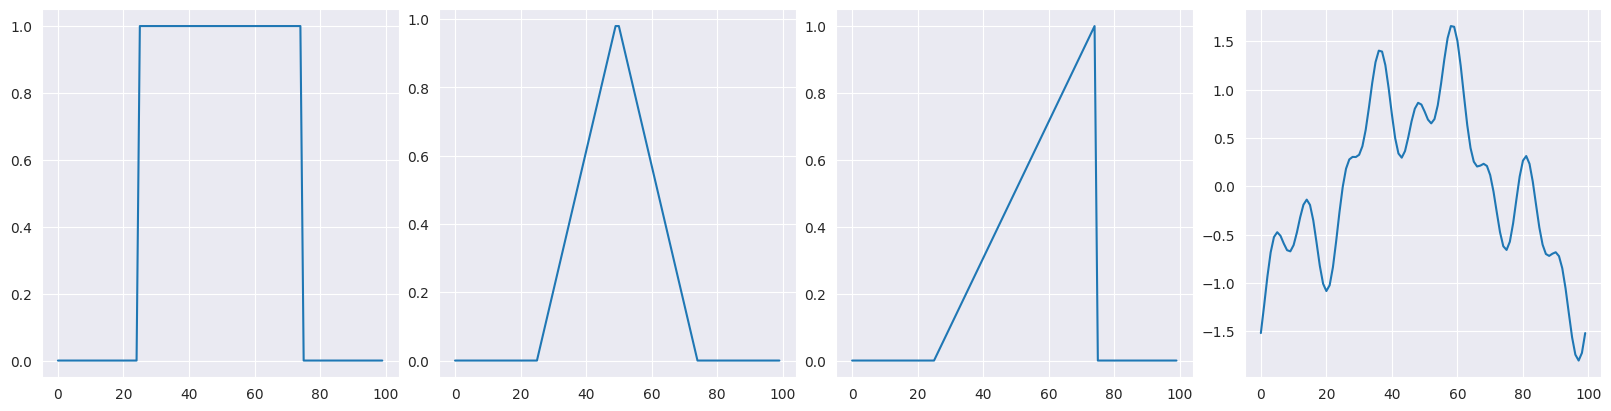

In [8]:
with sns.axes_style(style='darkgrid'):
    fig, axes = plt.subplots(1, 4, figsize=plt.figaspect(0.25))
    axes[0].plot(rectangle_function(100, shift=0, duty_cycle=0.5));
    axes[1].plot(triangle_hat_function(100, shift=0, duty_cycle=0.5));
    axes[2].plot(saw_function(100, shift=0, duty_cycle=0.5));
    axes[3].plot(sines_function(100, shift=0));

In [9]:
@ipywidgets.interact(
    T = (np.pi, 10. * np.pi, np.pi),
    fn = ['rectangle', 'triangle_hat', 'saw', 'sines'],
    shift = (-np.pi/2, np.pi/2, np.pi/8),
    K = (1, 100),
)
def fourier_series_demo(
    T: float = np.pi,
    fn: str = 'rectangle',
    shift: float = 0.,
    K: int = 20
) -> None:
    # Time axis
    dt = 0.001
    t = np.arange(-T/2, T/2, dt)
    # Compute function values
    if fn == 'rectangle':
        f = rectangle_function(len(t), shift=int(shift/dt), duty_cycle=np.pi/T/2)
    elif fn == 'triangle_hat':
        f = triangle_hat_function(len(t), shift=int(shift/dt), duty_cycle=np.pi/T/2)
    elif fn == 'saw':
        f = saw_function(len(t), shift=int(shift/dt), duty_cycle=np.pi/T/2)
    elif fn == 'sines':
        f = sines_function(len(t), shift=int(shift/dt))
    # Project the function onto the Fouries basis
    a = np.zeros(K)
    b = np.zeros(K)
    a[0] = 1. / T * np.sum(f) * dt  # cos(0) = 1
    f_approx = a[0] * np.ones(len(t))  # Fourier series
    err = np.zeros(K)
    err[0] = np.sqrt(np.mean((f_approx - f) ** 2))
    for k in range(1, K):
        cos = np.cos(k * 2. * np.pi / T * t)
        sin = np.sin(k * 2. * np.pi / T * t)
        a[k] = 2. / T * np.sum(f * cos) * dt  # dot product of f and cos(k)
        b[k] = 2. / T * np.sum(f * sin) * dt  # dot product of f and sin(k)
        f_approx += a[k] * cos + b[k] * sin
        err[k] = np.sqrt(np.mean((f_approx - f) ** 2))
    # Plot sum(ak * cos(k) + bk * sin(k)) approximation of f
    with sns.axes_style(style='darkgrid'):
        fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
        axes[0].plot(t, f, label='$f(t)$')
        axes[0].plot(t, f_approx, label='$\\hat{f}(t)$')
        # axes[0].set_ylim(-0.5, 1.5)
        axes[0].set_xlabel('$t$')
        axes[0].set_title('$f(t)$ and the Fourier series approximation')
        axes[0].legend()
        axes[1].stem(a, markerfmt='C0o', label='$a_k$')
        axes[1].stem(b, markerfmt='C1o', label='$b_k$')
        axes[1].set_ylim(-1., 1.)
        axes[1].set_xlabel('$k$')
        axes[1].set_title('Fourier series coefficients $a_k, b_k$')
        axes[1].legend()
        axes[2].plot(err)
        axes[2].set_xlabel('$k$')
        axes[2].set_title('Approximation error')

interactive(children=(FloatSlider(value=3.141592653589793, description='T', max=31.41592653589793, min=3.14159…

## Complex Fourier series

- We can generalize to complex-valued functions $f(t) \in \mathbb{C}$.
- The series is a little bit different (notice the limits)
  $$
  f(t) = \sum_{k=-\infty}^{+\infty}{ c_k \cdot e^{\text{i} \cdot k \cdot \frac{2\pi}{T} \cdot t} }
  $$
  where
  - $c_k \in \mathbb{C}$ are *complex* Fourier coefficients.
- The $c_k$ is again a projection
  $$
  c_k = \frac{1}{T} \cdot \int_{-T/2}^{T/2}{ f(t) \cdot e^{-\text{i} \cdot k \cdot \frac{2\pi}{T} \cdot t} \cdot \text{d}t } \\
  $$
- By expading $e^{-\text{i} \cdot k \cdot \frac{2\pi}{T} \cdot t}$ using Euler's formula and after rearranging we get
  $$
  c_k = \frac{1}{2}\left( a_k - \text{i} \cdot b_k \right)
  $$
  where
  - $a_k, b_k$ is computed as above.
- It can be shown that $\langle e^{\text{i}\cdot k \cdot t}, e^{\text{i}\cdot l \cdot t}\rangle = 0$ for any $k \ne l$ and 1 for $k = l$, i.e. the basis onto which we project the function $f(t)$ is orthogonal.

## Fourier series $\rightarrow$ Fourier transform

- When expressing the function $f(t)$ as Fourier series, the result will be periodic with period $T$, since we're using periodic basis functions to begin with.
- Fourier transform corresponds to complex Fourier series with period $T$ increased to infinity, a.k.a. *aperiodic* function $f(t)$.
- If we set $T \rightarrow \infty$ and plug $c_k$ equation into the complex Fourier series, we take the limit
  $$
  f(t) = \lim_{T \rightarrow \infty}{
    \sum_{k=-\infty}^{+\infty}{
      \frac{1}{T} \cdot \int_{-T/2}^{+T/2}{ f(u) \cdot e^{-\text{i} \cdot k \cdot 2\pi/T \cdot u} \cdot \text{d}u}
      \cdot
      e^{\text{i} \cdot k \cdot 2\pi/T \cdot t}
      }
  } 
  $$
- If we make the substitution
  $$
  \Delta\omega = \frac{2\pi}{T}, \qquad \omega = k \cdot \Delta\omega
  $$
  the limit becomes
  $$
  f(t) = \lim_{\Delta\omega \rightarrow 0}{
    \sum_{k=-\infty}^{+\infty}{
      \frac{\Delta\omega}{2\pi} \cdot \int_{-\pi/\Delta\omega}^{+\pi/\Delta\omega}{ f(u) \cdot e^{-\text{i} \cdot k \cdot \Delta\omega \cdot u} \cdot \text{d}u}
      \cdot
      e^{\text{i} \cdot k \cdot \Delta\omega \cdot t}
      }
  } 
  $$
- The infinitesimally small $\Delta\omega$ becomes $\text{d}\omega$,  
  which means the sum will become an integral,  
  and after moving $\text{d}\omega$ to the end we get
  $$
  f(t) = \int_{-\infty}^{+\infty}{
    \frac{1}{2\pi}
    \cdot 
    \underbrace{
      \int_{-\infty}^{+\infty}{
        f(u) \cdot e^{-\text{i} \cdot \omega \cdot u} \cdot \text{d}u
      }
    }_{\text{(Forward) Fourier transform}}
    \cdot
    e^{\text{i} \cdot \omega \cdot t} \cdot \text{d}\omega
  } 
  $$
- The inner integral is the **Fourier transform** $\mathcal{F}$
  $$
  F(\omega) = \mathcal{F}(f(t)) = \int_{-\infty}^{+\infty}{ f(t) \cdot e^{-\text{i} \cdot \omega \cdot t} \cdot \text{d}t }
  $$
  where
  - $\omega \in \mathbb{R}$ is the frequency with infinite resolution,
  - $F(\omega)$ is the **spectrum** as a *continuous* function of $\omega$.
- The outer integral is the ***inverse* Fourier transform** $\mathcal{F}^{-1}$
  $$
  f(t) = \mathcal{F}^{-1}(F(\omega)) = \frac{1}{2\pi} \cdot \int_{-\infty}^{+\infty}{ F(\omega) \cdot e^{\text{i} \cdot \omega \cdot t} \cdot \text{d}\omega }
  $$

# Discrete Fourier transform

- Up until now, we have assumed *continuous* functions $f(t)$.
- Such functions are obviously impractical or even impossible to work with when digitally processing on a computer.
- As a result, in reality we almost always work with *discrete digital* signals.

## Discrete-time Fourier transform (DTFT)

- In the following we'll rename the *continuous* function $f(t)$ above to $f_c(t)$.
- Informally (see [[Hayes11](https://www.mhprofessional.com/schaums-outline-of-digital-signal-processing-2nd-edition-9780071635097-usa)] for a more rigorous derivation), when **sampling** $f_c(t)$ at regular intervals $\Delta t$, in the Fourier transform above
  - $t$ becomes $n \cdot \Delta t$ for all integer multiples $n \in \mathbb{Z}$,
  - and $\text{d}t$ becomes $\Delta t$.
- As a result, the Fourier transform of $f(n)$ will be
  $$
  F(\omega) \approx \sum_{n=-\infty}^{+\infty}{ \Delta t \cdot f_c(n \cdot \Delta t) \cdot e^{-\text{i} \cdot \omega_a \cdot n \cdot \Delta t}}
  $$
- We may notice that the frequency $\omega_a$ is scaled by $\Delta t$. We often call it the *digital* frequency
  $$
  \omega = \omega_a \cdot \Delta t = 2\pi\cdot\frac{\Delta t}{T}
  $$
  and it is the analog signal's angular frequency $\omega_a$ normalized by the sampling frequency $1/\Delta t$. Its units are radians (unitless).
- We may also notice that the function $f_c$ is scaled by $\Delta t$ as well. We'll denote this as the sampled function  
  $$
  f(n) = \Delta t \cdot f_c(n \cdot \Delta t) \approx \int_{-\infty}^{+\infty}{ f_c(t) \cdot \delta(t - n \cdot \Delta t) \cdot \text{d}t}
  $$
- The two substitutions result in the common definition of **discrete-time Fourier transform (DTFT)**
  $$
  F(\omega) = \sum_{n=-\infty}^{+\infty}{ f(n) \cdot e^{-\text{i} \cdot \omega \cdot n}}
  $$
- If the (CT)FT of $f_c(t)$ is $F_c(\omega_a)$, and the DTFT of $f(n)$ is $F(\omega)$, then
  $$
  F(\omega) = \frac{1}{\Delta t} \cdot \sum_{k=-\infty}^{+\infty}{ F_c\left( \text{i} \cdot \frac{\omega}{\Delta t} - \text{i} \cdot \frac{2\pi \cdot k}{\Delta t} \right) }
  $$,
  see [[Hayes11](https://www.mhprofessional.com/schaums-outline-of-digital-signal-processing-2nd-edition-9780071635097-usa)] for complete derivation.
- Since the $F(\omega)$ is $2\pi$-periodic, the **inverse DTFT** is
  $$
  f(n) = \frac{1}{2\pi} \cdot \int_{0}^{2\pi}{ F(\omega) \cdot e^{\text{i} \cdot \omega \cdot n} \cdot \text{d}\omega}
  $$

## Sampling theorem and aliasing

- From the definition of DTFT, we can see that $F(\omega)$ is a conitnuous periodic function with period $2\pi$, since $e^{-\text{i} \cdot \omega \cdot n} = e^{-\text{i} \cdot (\omega + 2\pi) \cdot n}$ when $n$ is integer.
- This periodicity is explicitly formulated in the relation of FT and DTFT, in which we see that the spectrum $F$ of the discrete function $f(n)$ is an infinite sum of shifted and scaled spectrums $F_c$ of the original signal $f_c(t)$.
- Suppose that the original signal $f_c(t)$ is band-limited, meaning $F_c(\omega_c) = 0$ for $|\omega_c| \gt \omega_{\text{max}}$.
- An illustration of such spectrum and its shifted "replicas" is in the Fig. 18.8 (a) and (b) of the book [Burger22], see below.

<figure class="image">
  <img src="../figures/frequency_domain-dtft_aliasing.png" alt="" style="width: 6.4in"/>
  <figcaption>
    Spectral effects of sampling.
    Source: [Burger22], Fig. 18.8
  </figcaption>
</figure>

**Sampling theorem**
- As long as the width of the spectrum is low enough, the replicas will not overlap.
- Because of symmetries the spectrum of $f_c(t)$ is $2\cdot\omega_{\text{max}}$ wide and after sampling it is scaled by $\Delta t$, so we need
  $$
  2\cdot\omega_{\text{max}} \cdot \Delta t \lt 2\pi
  $$
  which after dividing by $\Delta t$ boils down to
  $$
  \omega_s \gt 2 \cdot \omega_\text{max} \\
  $$
  where $\omega_s = 2\pi/\Delta t$ is the sampling frequency in radians per second.
- This is called the **Shannon-Nyquist sampling theorem**, but goes by many other names too.
- If the Shannon-Nyquist condition holds, there is no information lost due to sampling and the original analog signal may be reconstructed perfectly.

**Aliasing**
- If the maximum frequency $\omega_{\text{max}}$ in the signal is too high or equivalently, the sampling rate $\omega_s$ too low, the spectrums will overlap and add together.
- All components with $|\omega| \gt \omega_\text{max}$ will be added to (*"aliased as"*) components from the mirroring side of the spectrum.
- The effect is illustrated in Fig 18.8 (c).
- The overlap means we modify the original spectrum, i.e. **lose information**.
- When reconstructing from modified spectrum, the aliased frequencies will create unwanted effects.
- In case of images, they will manifest as [Moiré pattern](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern), see figure below.

<figure class="image">
  <img src="../figures/frequency_domain-moire.png" alt="" style="width: 6.4in"/>
  <figcaption>
    Moiré pattern.
    Source: <a href=https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem>Wikipedia</a>
  </figcaption>
</figure>

## Discrete Fourier transform (DFT)

- In practice, not only do we work with discrete signals, but more often than not the sequences are of finite length.
- In terms of the theory above, we usually assume $T \lt \infty$, which implicitly assumes periodicity of $f(n)$.
- The usual convention is to define $f(n)$ for $n = 0, \ldots, N-1$, where the number of samples
  $$
  N = \frac{T}{\Delta t}
  $$
- Since $\omega = 2\pi\Delta t/T$, we're effectively sampling the DTFT spectrum at regular intervals of length $2\pi/N$, which means we can only get $N$ distinct digital frequencies $\omega_k = k \cdot 2\pi / N$ for $k = 0, \ldots, N-1$.
- So, the DFT spectrum can be viewed as and corresponds to **$N$-point sample of DTFT spectrum**, which is $2\pi$ wide.
- So, the DTFT for finite discrete function $f(n)$ becomes the **discrete Fourier transform (DFT)**
  $$
  F(\omega_k) = F\left(k \cdot \frac{2\pi}{N}\right) = \sum_{n=0}^{N-1}{ f(n) \cdot e^{-\text{i} \cdot k \cdot \frac{2\pi}{N} \cdot n} }
  $$
- As a result, **the spectrum $F(\omega_k)$ of $f(n)$ is also discrete**.
- This agrees with previous discussion of Fourier series and periodic functions.
- By limitting the number of samples in the inverse DTFT,
  - the integral becomes a sum,
  - and $\text{d}\omega$ becomes $\Delta\omega = 2\pi/N$.
- And so, after simplifying we'll obtain the **inverse DFT**
  $$
  f(n) = \frac{1}{N} \cdot \sum_{k=0}^{N-1}{ F\left(\omega_k\right) \cdot e^{\text{i} \cdot k \cdot \frac{2\pi}{N} \cdot n} }
  $$

### DFT as an orthogonal transformation

- Using a notational simplification
  $$
  w = e^{ -\text{i} \cdot \frac{2\pi}{N} }
  $$
  the DFT can be written as a matrix-vector multiplication.
  $$
  \newcommand{\D}{\vphantom{w^{(N-1)^2}}}
  \begin{bmatrix}
    \D F(0) \\
    \D F(1) \\
    \D F(2) \\
    \vdots \\
    \D F(N-1)
  \end{bmatrix}
  =
  \underbrace{
    \begin{bmatrix}
      \D 1 & 1 & 1 & \ldots & 1 \\
      \D 1 & w & w^2 & \ldots & w^{N-1} \\
      \D 1 & w^2 & w^4 & \ldots & w^{2\cdot(N-1)} \\
      \vdots & \vdots & \vdots & \ddots & \vdots \\
      \D 1 & w^{(N-1)} & w^{2\cdot(N-1)} & \ldots & w^{(N-1)^2} \\
    \end{bmatrix}
  }_{\text{DFT matrix }\bold{W}}
  \cdot
  \begin{bmatrix}
    \D f(0) \\
    \D f(1) \\
    \D f(2) \\
    \vdots \\
    \D f(N-1)
  \end{bmatrix}
  $$
  or more compactly
  $$
  \bold{F} = \bold{W} \cdot \bold{f}
  $$
- Analogously, we can express the *inverse* DFT as
  $$
  \bold{f} = \frac{1}{N} \cdot \bold{W}^{\mathsf{H}} \cdot \bold{F}
  $$
  where $\mathsf{H}$ denotes complex conjugate transpose.
- We can see that $\bold{W}^\mathsf{H} \cdot \bold{W} = N \cdot \bold{I}$.
- If we normalize both forward and inverse DFTs by $1/\sqrt{N}$ instead of just one of them by $1/N$, the DFT can be considered an [orthogonal transformation](https://en.wikipedia.org/wiki/Orthogonal_transformation).

In [10]:
def dft(signal: np.ndarray, norm: bool = False) -> np.ndarray:
    n_samples = len(signal)
    omega = np.exp(-1j * 2 * np.pi / n_samples)
    rows, cols = np.mgrid[0:n_samples, 0:n_samples]
    dft_matrix = omega ** (rows * cols)
    spectrum = signal @ dft_matrix
    if norm:
        spectrum /= n_samples
    return spectrum

In [11]:
@ipywidgets.interact(
    N = (8, 1024, 8),
    fn = ['rectangle', 'triangle_hat', 'saw', 'sines'],
    shift = (-0.5, 0.5),
    noise_std = (0., 0.5, 0.01),
    norm = False,
    half = False,
)
def dft_demo(
    N: int = 256,
    fn: str = 'rectangle',
    shift: float = 0.,
    noise_std: float = 0.,
    norm: bool = False,
    half: bool = False,
) -> None:
    if fn == 'rectangle':
        f = rectangle_function(N, shift=int(shift*N))
    elif fn == 'triangle_hat':
        f = triangle_hat_function(N, shift=int(shift*N))
    elif fn == 'saw':
        f = saw_function(N, shift=int(shift*N))
    elif fn == 'sines':
        f = sines_function(N, shift=int(shift*N))
    if noise_std > 0.:
        f += noise_std * np.random.randn(len(f))
    f_dft = dft(f, norm=norm)
    f_dft_mag = np.abs(f_dft)
    f_dft_phase = np.arctan2(f_dft.real, f_dft.imag)
    omegas = np.linspace(0., 2 * np.pi, N)
    if half:
        omegas = omegas[:N//2+1]
        f_dft_mag = f_dft_mag[:N//2+1]
        f_dft_phase = f_dft_phase[:N//2+1]
    with sns.axes_style(style='darkgrid'):
        fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
        axes[0].plot(np.arange(N), f, label='$f(n)$')
        axes[0].set_xlabel('$n$')
        axes[0].set_ylabel('$f(n)$')
        axes[1].plot(omegas, f_dft_mag, label='$a_k$')
        axes[1].set_xlabel('$\\omega_k$ [rad]')
        axes[1].set_ylabel('$|F(k)|$')
        axes[2].plot(omegas, f_dft_phase)
        axes[2].set_xlabel('$\\omega_k$ [rad]')
        axes[2].set_ylabel('$\\varphi$ [rad]')

interactive(children=(IntSlider(value=256, description='N', max=1024, min=8, step=8), Dropdown(description='fn…

## Fast Fourier transform and implementations in Python

- The DFT as introduced above requires the number of multiplications that is quadratic w.r.t. input length $N$, i.e. $\mathcal{O}(N^2)$.
- Due to lots of symmetries, however, there is considerable redudancy that can be leveraged.
- The most well known efficient algorithm for computation of DFT is the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) due to Cooley and Tukey.
- Its history, however, can be traced back to 19th century and [Carl Friedrich Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss).
- FFT computes the DFT recursively for even and odd elements, effectively halving the size of the problem in each recursion, thereby achieving $\mathcal{O}(N\cdot\log N)$.
- See details e.g. in [Gilbert Strang's Linear Algebra, Lecture 26](https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/resources/lecture-26-complex-matrices-fast-fourier-transform/).
- There is a number of implementations of FFT in Python, most notably the ones in Numpy and Scipy.

In [12]:
print(dft(rectangle_function(8)))  # our manual implementation as matrix-vector product
print(np.fft.fft(rectangle_function(8)))
print(scipy.fft.fft(rectangle_function(8)))

[ 4.   +0.j -2.414-1.j  0.   -0.j  0.414+1.j -0.   +0.j  0.414-1.j  0.   +0.j -2.414+1.j]
[ 4.   +0.j -2.414-1.j  0.   +0.j  0.414+1.j  0.   +0.j  0.414-1.j  0.   +0.j -2.414+1.j]
[ 4.   -0.j -2.414-1.j  0.   -0.j  0.414+1.j  0.   -0.j  0.414-1.j  0.   +0.j -2.414+1.j]


# Discrete Fourier transform in 2D

- An image can be considered a two-dimensional discrete function $f(m,n)$ that is defined for all pairs of $m = 1, \ldots, M$ and $n = 1, \ldots, N$.
- The DFT can be generalized to arbitrary dimensionality, so we're effectively assuming that $f(m,n)$ is periodic with vertical period $M$ and horizontal period $N$.
- **2D DFT** for such functions is defined as
  $$
  F(k,l) =
    \sum_{m=0}^{M-1}{
      \sum_{n=0}^{N-1}{
        f(m,n)
        \cdot
        e^{-\text{i} \cdot l \cdot \frac{2\pi}{N} \cdot n}
        \cdot
        e^{-\text{i} \cdot k \cdot \frac{2\pi}{M} \cdot m}
      }
    }
  $$
- If we rearrange the definition above as
  $$
  F(k,l) =
    \sum_{m=0}^{M-1}{
      \underbrace{
        \left(
          \sum_{n=0}^{N-1}{
            f(m,n)
            \cdot
            e^{-\text{i} \cdot l \cdot \frac{2\pi}{N} \cdot n}
          }
        \right)
      }_{\text{1-dimensional DFT of }m\text{-th row}}
      \cdot
      e^{-\text{i} \cdot k \cdot \frac{2\pi}{M} \cdot m}
    }
  $$
  we see that the inner sum corresponds to 1-dimensional DFT of every row  
  and the outer sum performs 1-dimensional DFT of every column of the row-wise DFT.
- Notice that whether we first compute over rows and then over columns or vice versa does not matter, because we can rearrange the definition in arbitrary order.
- Written more compactly we see that 2D DFT is a sequential application of 1D DFT e.g. first per columns, then per rows, i.e.
  $$
  %F(k,l) = \text{DFT}_m(\text{DFT}_n(f(m,n)))
  \text{DFT2}(f) = \text{DFT1}(\text{DFT1}(f)^\top)^\top
  $$
  <!-- where $\text{DFT}_m$ and $\text{DFT}_n$ denote 1D DFT for each row and 1D DFT for each column, respectively. -->  
  where $\text{DFT1}$ denotes 1D DFT applied to every row of its 2D input.
- The **inverse 2D DFT** is
  $$
  f(m,n) =
    \frac{1}{M\cdot N}
    \cdot
    \sum_{m=0}^{M-1}{
      \sum_{n=0}^{N-1}{
        f(m,n)
        \cdot
        e^{\text{i} \cdot l \cdot \frac{2\pi}{N} \cdot n}
        \cdot
        e^{\text{i} \cdot k \cdot \frac{2\pi}{M} \cdot m}
      }
    }
  $$

In [13]:
# Demonstrate that 2D DFT via two 1D DFTs is equivalent to direct 2D DFT
gray = skimage.io.imread('../data/brunswick3.jpg', as_gray=True)
gray_dft1 = scipy.fft.fft(scipy.fft.fft(gray).T).T  # scipy.fft.fft applies 1D fft over rows ("batch" FFT)
gray_dft2 = scipy.fft.fft2(gray)  # direct 2D FFT
np.sum(np.abs(gray_dft1.real - gray_dft2.real) + np.abs(gray_dft1.imag - gray_dft2.imag))  # should be zero

np.float64(1.8998489087485027e-08)

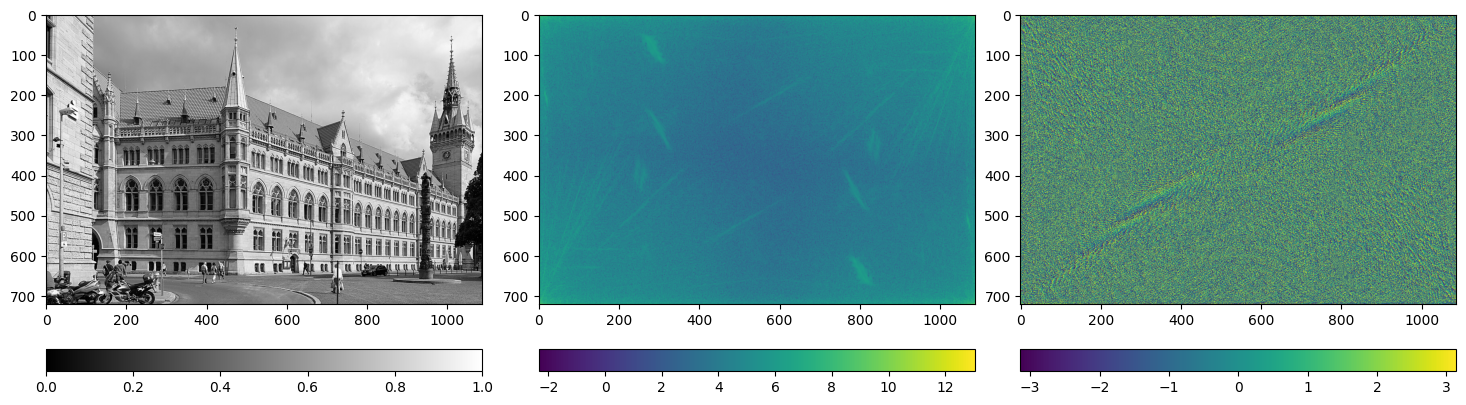

In [14]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
im0 = axes[0].imshow(gray, cmap='gray', vmin=0, vmax=1);
fig.colorbar(im0, ax=axes[0], orientation='horizontal');
im1 = axes[1].imshow(np.log(np.abs(gray_dft2)));
fig.colorbar(im1, ax=axes[1], orientation='horizontal');
im2 = axes[2].imshow(np.arctan2(gray_dft2.imag, gray_dft2.real));
fig.colorbar(im2, ax=axes[2], orientation='horizontal');

## Basis functions

- From the definition of the 2D DFT we see that the basis functions are 2D exponentials $e^{-\text{i} \cdot k \cdot 2\pi / M \cdot m - \text{i} \cdot l \cdot 2\pi / N \cdot n}$.
- If we expand them using Euler's formula, we'll get two 2D cosine and sine basis functions
  $$
  c_{k,l}(m,n) = \cos\left(k \cdot \frac{2\pi}{M} \cdot m + l \cdot \frac{2\pi}{N} \cdot n\right)
  \qquad
  s_{k,l}(m,n) = \sin\left(k \cdot \frac{2\pi}{M} \cdot m + l \cdot \frac{2\pi}{N} \cdot n\right)
  $$
  where $k$ and $l$ specify how many cycles the basis functions perform in vertical and horizontal directions, respectively.
- Similarly to the 1D case, every image can be decomposed into a weighted sum of the 2D sines and cosines.
- We visualize the basis functions below.

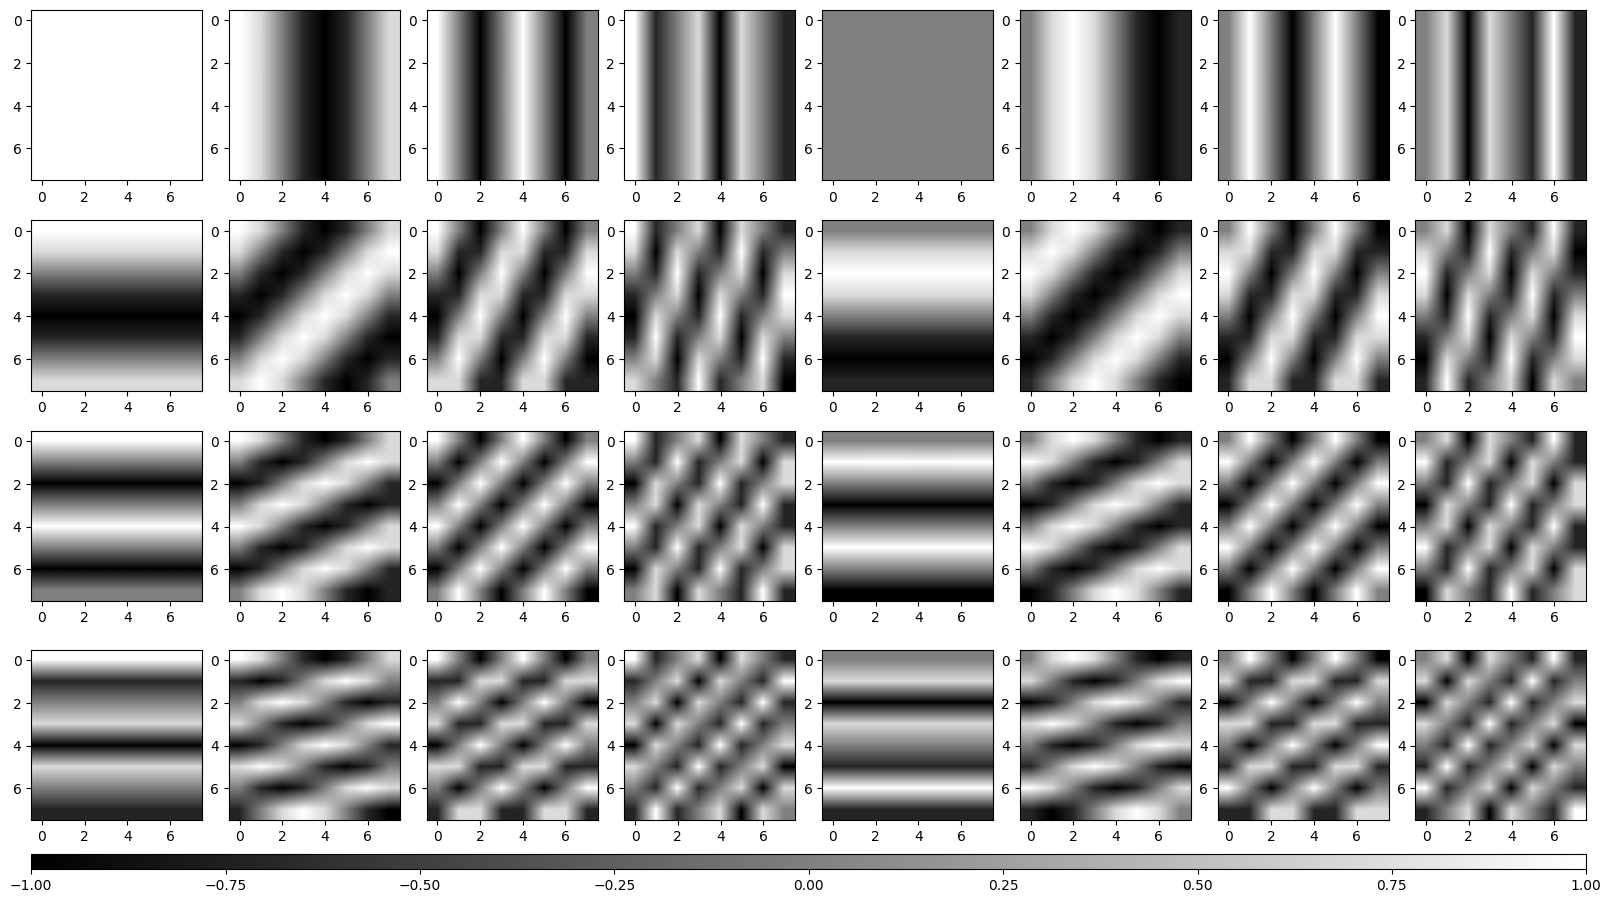

In [15]:
fig, axes = plt.subplots(4, 8, figsize=(16, 9))
ih, iw = 8, 8
m_pad, n_pad = np.mgrid[0:ih, 0:iw]
for k in range(4):
    for l in range(4):
        im = axes[k,  l ].imshow(np.cos(k * 2 * np.pi / ih * m_pad + l * 2 * np.pi / iw * n_pad), cmap='gray', vmin=-1, vmax=+1, interpolation='bilinear')
        im = axes[k, l+4].imshow(np.sin(k * 2 * np.pi / ih * m_pad + l * 2 * np.pi / iw * n_pad), cmap='gray', vmin=-1, vmax=+1, interpolation='bilinear')
fig.colorbar(im, ax=axes[-1, :], orientation='horizontal', aspect=100);

## Ordering of frequencies and visualization of the 2D DFT

- Analogous to 1D, the 2D spectrum is also periodic.
- For real-valued images it is also *symmetric* about the origin.
- It is therefore common to shift quadrants of the spectrum such that the origin is at the center, see the following illustration.
- The shifting is also convenient for filtering in frequency domain.
- It is important not to forget to shift the quadrants to their original positions before transforming back to spatial domain using inverse DFT.

<figure class="image">
  <img src="../figures/frequency_domain-fftshift.png" alt="" style="width: 6.4in"/>
  <figcaption>
    FFT shift.
    Source: [Burger22], Fig. 19.3
  </figcaption>
</figure>

- In most images, the lowest frequencies have the highest energy.
- The magnitude ratio of low and high frequencies can be quite significant.
- Therefore, we often display *square root* or *logarithm* of the spectrum instead of the magnitudes in order to make the higher frequencies more visible.

In [16]:
gray_dft = scipy.fft.fftshift(gray_dft2)

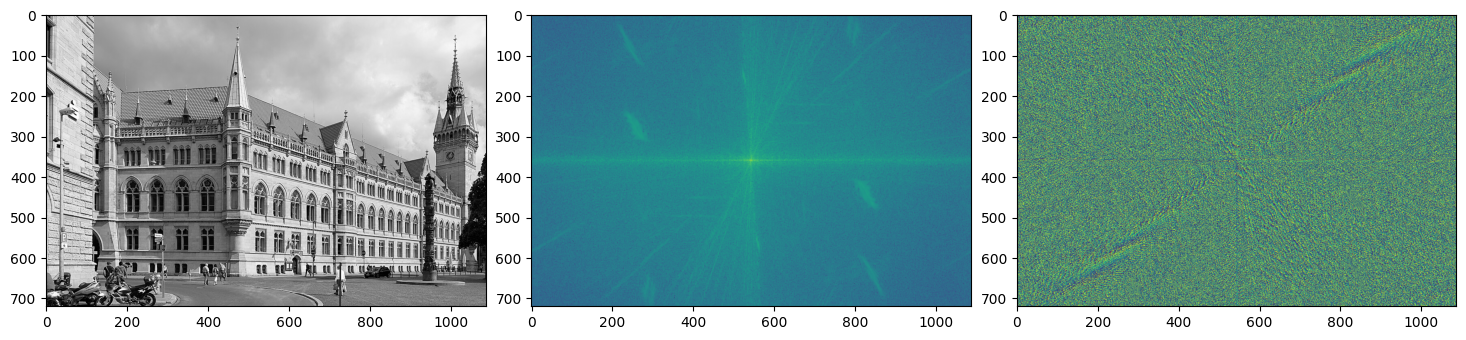

In [17]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=1);
axes[1].imshow(np.log(np.abs(gray_dft)));
axes[2].imshow(np.arctan2(gray_dft.imag, gray_dft.real));

## Frequencies and orientation in 2D

- If an $M \times N$ contains a periodic pattern with effective frequency $1/\tau$ and orientation $\psi$, the associated frequency coefficients are found at positions [Burger22]
  $$
  \begin{bmatrix}
    m \\
    n
  \end{bmatrix}
  =
  \pm\frac{1}{\tau}
  \cdot
  \begin{bmatrix}
    M \cdot \cos(\phi) \\
    N \cdot \sin(\phi)
  \end{bmatrix}
  $$

<figure class="image">
  <img src="../figures/frequency_domain-frequency_orientation.png" alt="" style="width: 6.4in"/>
  <figcaption>
    2D DFT frequency and orientation.
    Source: [Burger22], Fig. 19.5
  </figcaption>
</figure>

In [18]:
rot = skimage.transform.rotate(gray, angle=30, resize=False)
rot_dft = scipy.fft.fftshift(scipy.fft.fft2(rot))

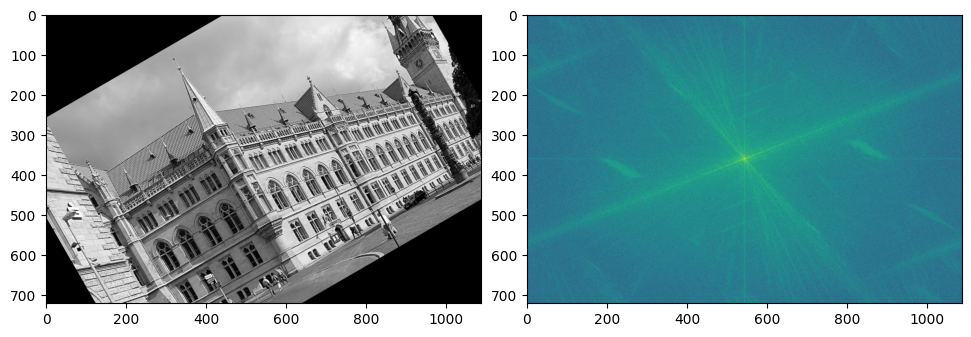

In [19]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
axes[0].imshow(rot, cmap='gray', vmin=0, vmax=1);
axes[1].imshow(np.log(np.abs(rot_dft)));    

## Effects of periodicity and windowing

- Remember that we assume periodic image function $f(m,n)$ in both horizontal and vertical directions.
- Therefore, the transitions at the borders between the replicas of the image are also part of the image.

<figure class="image">
  <img src="../figures/frequency_domain-image_periodicity.png" alt="" style="width: 6.4in"/>
  <figcaption>
    Effects of image periodicity in the 2D spectrum.
    Source: [Burger22], Fig. 19.8
  </figcaption>
</figure>

- A common solution is to multiply the image by some **window** function that has low values close to borders
  $$
  \hat{f}(m,n) = f(m,n) \cdot w(m,n)
  $$
  prior to computing the DFT.
- This will, of course, have effects on the computed spectrum.
- The window function should be as wide as possible, drop off to zero close to borders, but not too rapidly to preserve the original spectrum as much as possible.

# Linear filtering in frequency domain

- In the [`spatial-filtering`](spatial_filtering.ipynb) lecture we've seen that *linear* filtering in *spatial domain* is a convolution of a signal (e.g. image) $f$ and a filter $h$
  $$
  g = f * h
  $$
- In contrast, filtering in the *frequency domain* consists of three steps
  1. Convert the image $f(m,n)$ into the frequency domain using DFT.
  2. Modify the spectrum $F(k,l)$ of the image $f(m,n)$.
  3. Convert the modified spectrum $F'(k,l)$ back to spatial domain to get the filtered image $f'(m,n)$.
- As we will shortly see, linear filtering in one domain is equivalent to the other.
- There are a few advantages of filtering in the *frequency* domain:
  - Because of FFT's $\mathcal{O}(N \cdot \log N)$ complexity we can speedup computation for spatially large filters which would otherwise require $\mathcal{O}(N^2)$.
  - Can be conceptually simpler to express some operations in the frequency domain, e.g. band-pass filters.

## Convolution theorem

- The Fourier transform has many desirable properties (that hold for DFT as well) making it attractive for signal filtering.
- One of the most important is the [**convolution theorem**](https://en.wikipedia.org/wiki/Convolution_theorem) which states that  
  ***convolution between* two signals corresponds to *pointwise product* of their spectrums**,  
  formally
  $$
  (f * h) = \mathcal{F}^{-1}(F \cdot H)
  $$
  where
  - $F = \mathcal{F}(f)$,
  - $H = \mathcal{F}(h)$.
- The theorem also holds the other way around, meaning that product of two signals corresponds to convolution of their spectrums, i.e.
  $$
  (f \cdot h) = \mathcal{F}^{-1}(F * H)
  $$
  where we assume both $f$ and $h$ are $M \times N$ large.
- For [**cross-correlation**](https://en.wikipedia.org/wiki/Cross-correlation), the equivalence is
  $$
  (f \star h) = \mathcal{F}^{-1}(F \cdot H^\ast)
  $$
  where $H^\ast$ is complex conjugate of $H$.  
  Notice that due to complex conjugation, the operation is no longer commutative.

**Note**
- The convolution theorem equivalence to spatial filtering is exact.
- This means that even though we work with complex numbers, the result $(f * h)$ should in theory be real.
- In practice, however, due to numerical imprecissions, the result will have small but nonzero imaginary parts.
- In order to get rid off the imaginary values, we simply take the real part, i.e. we do
  $$
  (f * h) = \mathrm{Re}(\mathcal{F}^{-1}(F \cdot H))
  $$

## Blurring an image by filtering in frequency domain

- The above means that when we filter an image $f$ with a *linear* filter $h$ in the *spatial* domain using a convolution
  $$
  g = f * h
  $$,  
  we can do the equivalent filtering in the *frequency* domain as
  1. Compute the DFT of the image $F = \mathcal{F}(f)$,
  2. Compute the DFT of the filter $H = \mathcal{F}(h)$,
  3. Multiply both spectrums $G = F \cdot H$,
  4. Convert back to the spatial domain using inverse DFT $g = \mathcal{F}^{-1}(G)$.
- In the example below, we'll first create the filter directly in the frequency domain and only later show the equivalence.

### 0. Load the image

In [20]:
gray = skimage.io.imread('../data/brunswick3.jpg', as_gray=True)
gray = skimage.transform.rescale(gray, scale=0.3)  # to make spatial convolution faster (used for verification)
gray.shape, gray.dtype

((216, 326), dtype('float64'))

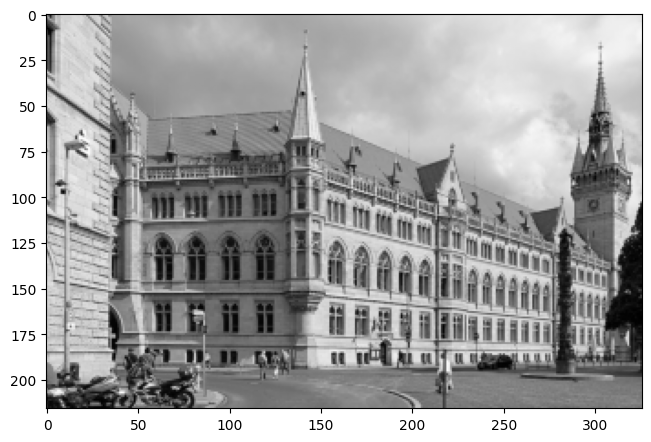

In [21]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=1);

### 1. Compute the DFT

- We are going to center the spectrum in order to make the creation of the filter transfer function simpler.

In [22]:
gray_dft = scipy.fft.fft2(gray)
gray_dft = scipy.fft.fftshift(gray_dft)
gray_dft.shape, gray_dft.dtype

((216, 326), dtype('complex128'))

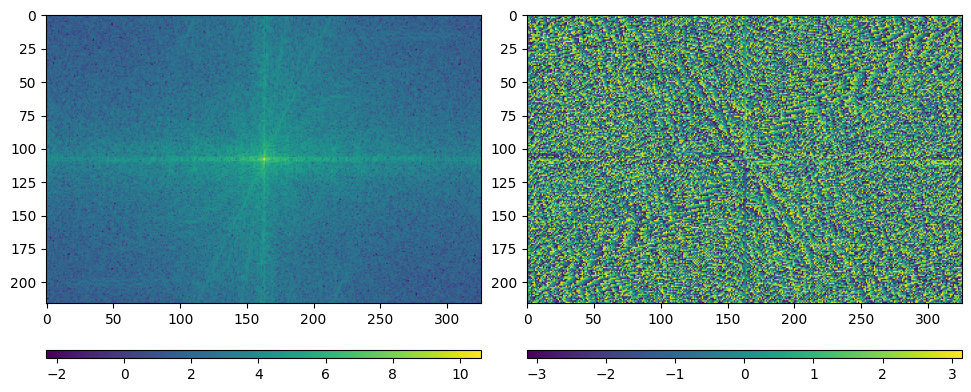

In [23]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(np.log(np.abs(gray_dft)));
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(gray_dft.imag, gray_dft.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);

### 2. Create the filter transfer function in the frequency domain

- Since we haven't defined any spatial kernel so far, we are going to create it directly in the frequency domain (i.e. we'll create its spectrum).
- Remember we want to *blur* the image.
- Essentially, this means we want to zero out high frequencies in our image while simultaneously preserving the low frequencies as they are.
- So, the filter spectrum will have zeros at locations corresponding to high frequencies and ones at low frequencies.
- Informally, we'll "paint" a circle of ones at the center of the filter spectrum (filter transfer function) $H$.

In [24]:
h, w = gray.shape
m, n = np.mgrid[0:h, 0:w]
kernel_dft = np.zeros_like(gray_dft)  # filter will be zeros everywhere
kernel_dft[(m / h - 1 / 2) **2 + (n / w - 1 / 2)**2 < 0.25**2] = 1 + 0j  # except a "circle" in the middle (image is not square)
kernel_dft.shape, kernel_dft.dtype, kernel_dft.min(), kernel_dft.max()

((216, 326), dtype('complex128'), np.complex128(0j), np.complex128(1+0j))

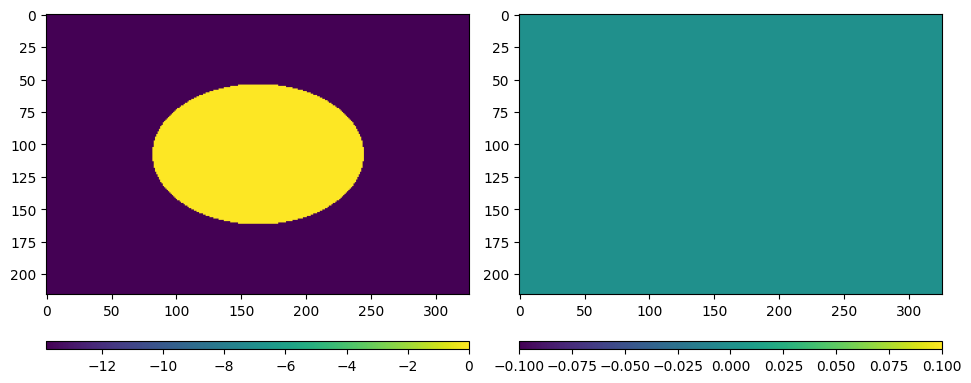

In [25]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(np.log(1e-6 + np.abs(kernel_dft)));  # +1e-6 to prevent warning due to log(0)
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(kernel_dft.imag, kernel_dft.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);

### 3. Compute the product of spectrums

- Now we simply element-wise multiply the spectrum of the image and that of the kernel.

In [26]:
gray_filt_dft = gray_dft * kernel_dft
gray_filt_dft.shape, gray_filt_dft.dtype

((216, 326), dtype('complex128'))

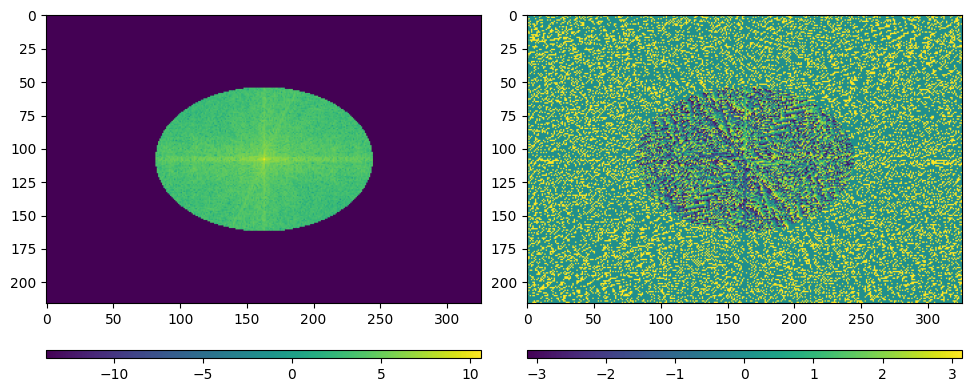

In [27]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(np.log(1e-6 + np.abs(gray_filt_dft)));  # +1e-6 to prevent warning due to log(0)
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(gray_filt_dft.imag, gray_filt_dft.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);

### 4. Transform back to spatial domain using invese DFT

In [28]:
gray_filt = scipy.fft.ifftshift(gray_filt_dft)  # move origin back to corners
gray_filt = scipy.fft.ifft2(gray_filt)  # to spatial domain
gray_filt = gray_filt.real  # ignore imaginary residue
gray_filt.shape, gray_filt.dtype, gray_filt.min(), gray_filt.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.10176796244918455),
 np.float64(1.0430547940449273))

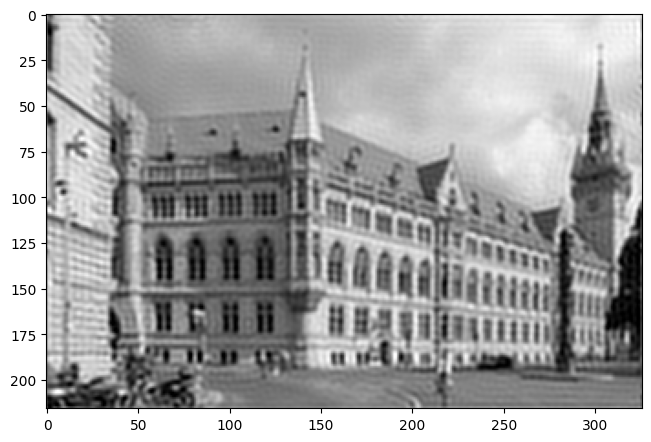

In [29]:
plt.imshow(gray_filt, cmap='gray', vmin=0, vmax=1);

### Equivalence to filtering in spatial domain

- We can perform the same linear filtering in the *spatial* domain and obtain the same result.
- We'll first transform the kernel into spatial domain using inverse DFT  
  $$
  h = \mathcal{F}^{-1}(H)
  $$  
  and then convolve it with the image  
  $$
  g = f * h
  $$
- By convention, convolution assumes the origin of the kernel to be at its center.
- So, we will shift the kernel using [`np.roll`](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) both horizontally and vertically.

In [30]:
kernel = scipy.fft.ifft2(scipy.fft.ifftshift(kernel_dft)).real  # transform to spatial domain
kernel = np.roll(kernel, h // 2, axis=0)
kernel = np.roll(kernel, w // 2, axis=1)
kernel.shape, kernel.dtype, kernel.min(), kernel.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.025620565106195422),
 np.float64(0.19621960917973186))

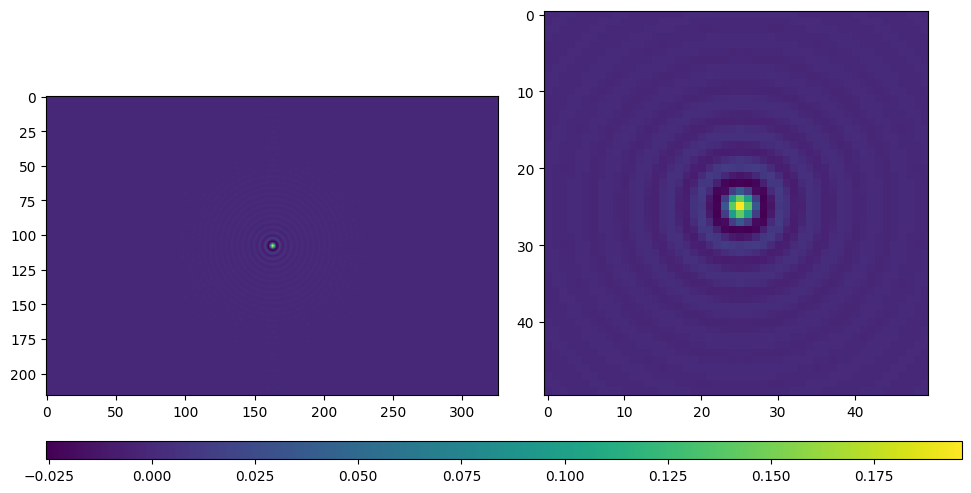

In [31]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im = axes[0].imshow(kernel);  # imshow the whole kernel
axes[1].imshow(kernel[h//2-25:h//2+25, w//2-25:w//2+25])  # zoom in on the center
fig.colorbar(im, ax=axes, orientation='horizontal', aspect=50);

In [ ]:
# Perform convolution in *spatial* domain
# WARNING: this might take a long time (the `kernel` is large - the same size as the image)
gray_filt_ = scipy.ndimage.convolve(gray, kernel, mode='constant', cval=0.)
gray_filt_.shape, gray_filt_.dtype, gray_filt_.min(), gray_filt_.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.10137893756290345),
 np.float64(1.0461182988568183))

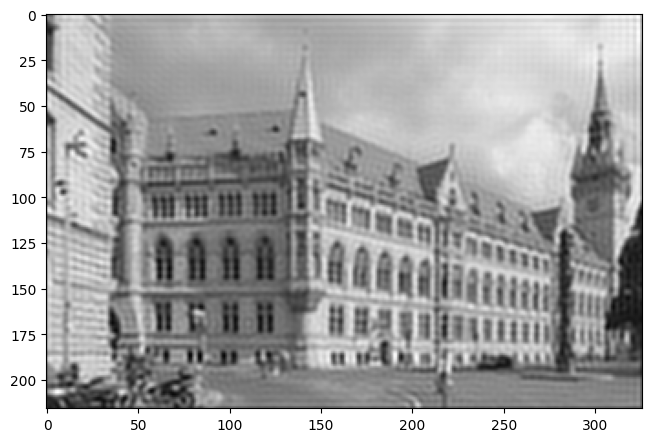

In [33]:
plt.imshow(gray_filt_, cmap='gray');

In [ ]:
np.mean(np.abs(gray_filt_ - gray_filt))  # should be very small, ideally zero

np.float64(0.008895238641158052)

- We can see the results are close but not the same.
- Let's show the absolute difference as an image.

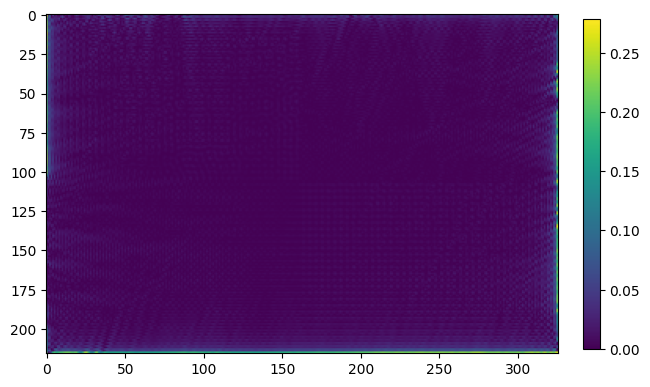

In [ ]:
plt.imshow(np.abs(gray_filt_ - gray_filt))
plt.colorbar(shrink=0.7);

### Circular convolution

- Again, we see that frequency and spatial filtering give similar results, but not quite the same.
- Most of the discrepancy is along the borders. Why?
- Even though DFT does not *explicitly* assume periodic signals $f(m[,n])$, the spectrum $F(k[,l])$ can be viewed as coefficients of Fourier series that corresponds to periodic expansion of $f$.
- As a result, the convolution theorem works as if both signals were periodic in spatial domain, i.e. $f(m,n) = f(m+M,n+N)$.
- This is called **circular convolution**.
- Remember, however, that regular convolution is defined such that if the kernel is not fully contained in the input signal at a particular location, the input is effectively *padded with zeros* to make up for the missing values, i.e. the values of the kernel that extend beyond borders are multiplied with zeros.
- In 1D, we can illustrate zero padding as `000000|abcdef|000000`.
- By comparing with circular convolution we see that filtering finite inputs in frequency domain corresponds to convolution with *periodic padding*.
- In 1D that is `abcdef|acbdef|abcdef`.
- So, we can show the equivalence just by changing the border handling (padding).

In [ ]:
# WARNING: this might take a long time (the `kernel` is large - the same size as the image)
gray_filt_ = scipy.ndimage.convolve(gray, kernel, mode='wrap')  # use *periodic* padding (wrap)
gray_filt_.shape, gray_filt_.dtype, gray_filt_.min(), gray_filt_.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.10176796244918593),
 np.float64(1.0430547940449295))

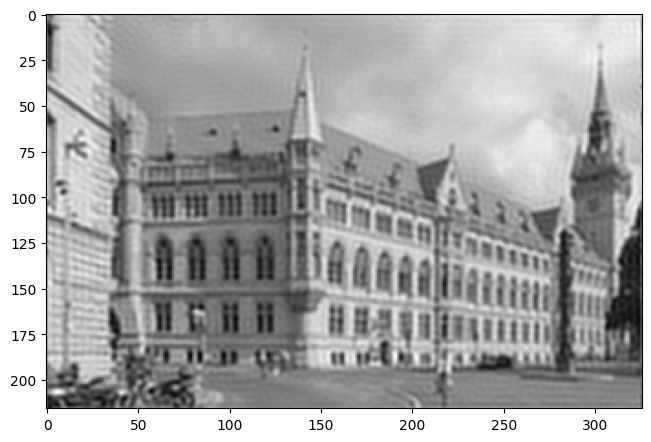

In [37]:
plt.imshow(gray_filt_, cmap='gray');

In [ ]:
np.mean(np.abs(gray_filt_ - gray_filt))  # now should be very small number

np.float64(3.894133056058907e-15)

## Blurring in frequency domain properly

- In the example above, we managed to show the equivalence by changing the padding mode of the convolution to periodic ("wrap").
- However, this violates the definition of linear filtering - that should be a convolution with *zero* padding.
- Instead of modifying linear filtering to make it behave like *circular* convolution, we should come up with a FFT-based filtering that is truly equivalent to convolution with *zero* padding.
- This requires few additional steps:
  1. **Pad the image with zeros,**
  2. Compute the DFT of the image $F = \mathcal{F}(f)$,
  3. Compute the DFT of the filter $H = \mathcal{F}(h)$,
  4. Multiply both spectrums $G = F \cdot H$,
  5. Convert back to the spatial domain using inverse DFT $g = \mathcal{F}^{-1}(G)$,
  6. **Crop the extra-padded pixels**.

### 1. Pad the image

- We need to manually pad the input such that the kernel never needs to extend over the borders.
- The maximum size of the output when convolving (`mode='full'`) is $N + K - 1$, where $K$ is the size of the kernel.
- Since when defining the filter in frequency domain both input and kernel have the same size $N = K$,  
  and FFT works best when size of its input is even (ideally a power of two),  
  we will pad the image to twice the size of itself.
- We will pad to the right and to the bottom. This way
  $$
  f_\text{pad}(m,n) = \begin{cases}
    f(m,n) & \quad \text{if} & \quad 0 \le n \lt N \\
    0 & \quad \text{if} &      \quad N \le n \lt 2\cdot N \\
    0 & \quad \text{if} &      \quad -N \le n \lt 0 \\
  \end{cases}
  $$
  and analogously for vertical direction.

In [39]:
h, w = gray.shape
gray_pad = np.zeros((2 * h, 2 * w))
gray_pad[:h, :w] = gray
gray_pad.shape, gray_pad.dtype

((432, 652), dtype('float64'))

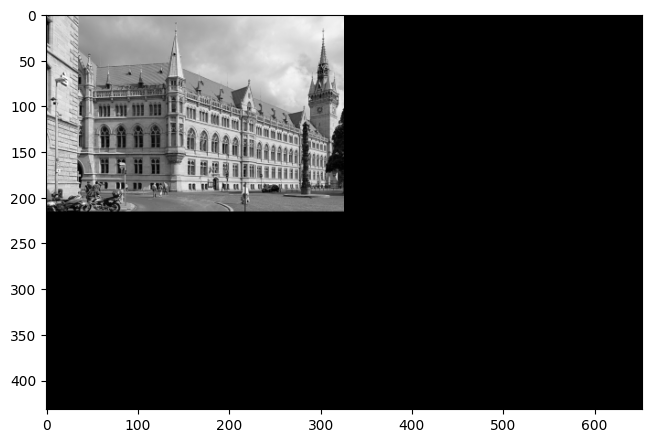

In [40]:
plt.imshow(gray_pad, cmap='gray', vmin=0, vmax=1);

### 2. Compute the DFT

In [41]:
gray_pad_dft = scipy.fft.fft2(gray_pad)
gray_pad_dft = scipy.fft.fftshift(gray_pad_dft)
gray_pad_dft.shape, gray_pad_dft.dtype

((432, 652), dtype('complex128'))

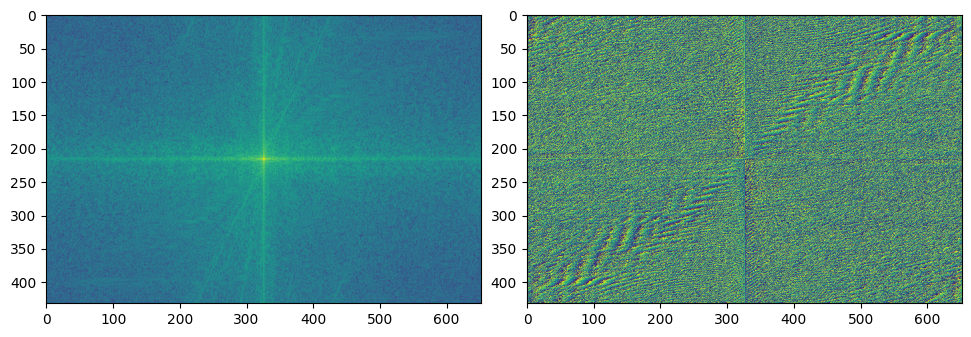

In [42]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
axes[0].imshow(np.log(np.abs(gray_pad_dft)));
axes[1].imshow(np.arctan2(gray_pad_dft.imag, gray_pad_dft.real));

### 3. Create the filter transfer function in the frequency domain

In [43]:
h_pad, w_pad = gray_pad.shape
m_pad, n_pad = np.mgrid[0:h_pad, 0:w_pad]
kernel_pad_dft = np.zeros_like(gray_pad_dft)  # filter will be zeros everywhere
kernel_pad_dft[(m_pad / h_pad - 1 / 2) **2 + (n_pad / w_pad - 1 / 2)**2 < 0.25**2] = 1 + 0j  # except a "circle" in the middle (image is not square)
kernel_pad_dft.shape, kernel_pad_dft.dtype, kernel_pad_dft.min(), kernel_pad_dft.max()

((432, 652), dtype('complex128'), np.complex128(0j), np.complex128(1+0j))

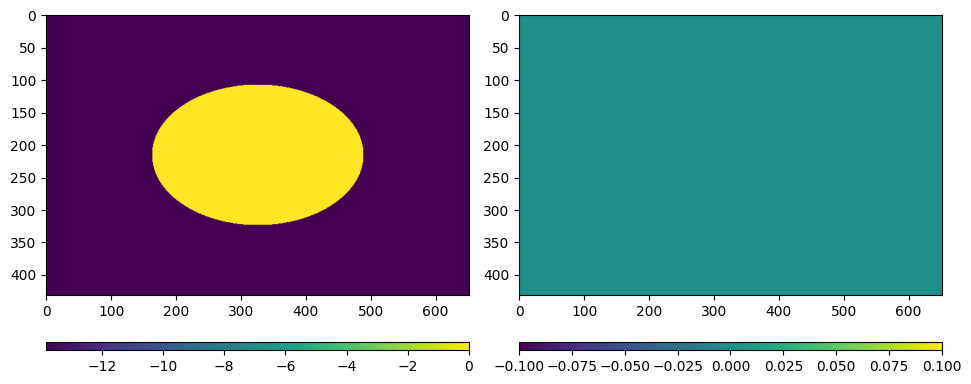

In [44]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(np.log(1e-6 + np.abs(kernel_pad_dft)));
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(kernel_pad_dft.imag, kernel_pad_dft.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);

### 4. Compute the product of spectrums

In [45]:
gray_pad_filt_dft = gray_pad_dft * kernel_pad_dft
gray_pad_filt_dft.shape, gray_pad_filt_dft.dtype

((432, 652), dtype('complex128'))

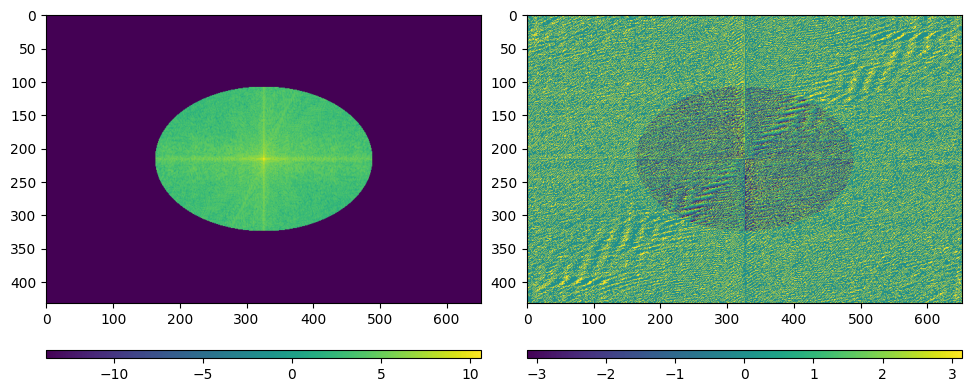

In [46]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im0 = axes[0].imshow(np.log(1e-6 + np.abs(gray_pad_filt_dft)));
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(gray_pad_filt_dft.imag, gray_pad_filt_dft.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);

### 5. Transform back to spatial domain using invese DFT

In [47]:
gray_pad_filt = scipy.fft.ifft2(scipy.fft.ifftshift(gray_pad_filt_dft)).real
gray_pad_filt.shape, gray_pad_filt.dtype

((432, 652), dtype('float64'))

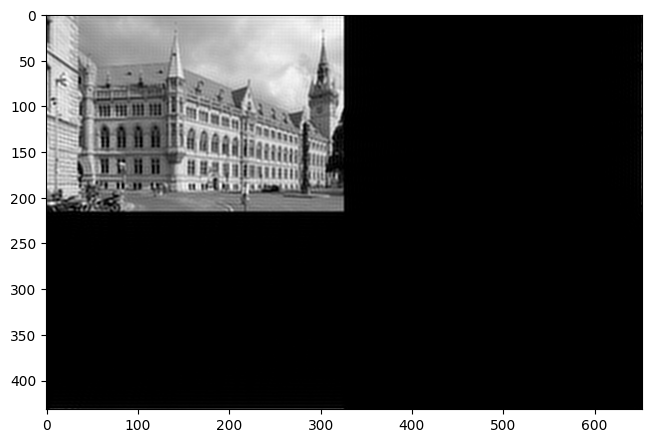

In [48]:
plt.imshow(gray_pad_filt, cmap='gray', vmin=0, vmax=1);

### 6. Extract the top-left quadrant and clip values

In [49]:
gray_filt = gray_pad_filt[:h, :w]
gray_filt.shape, gray_filt.dtype

((216, 326), dtype('float64'))

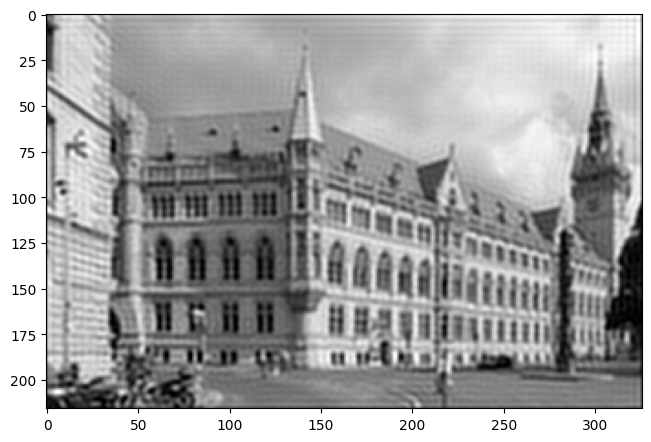

In [50]:
plt.imshow(gray_filt, cmap='gray', vmin=0, vmax=1);

### Equivalence to filtering in spatial domain

In [51]:
kernel = scipy.fft.ifft2(scipy.fft.ifftshift(kernel_pad_dft)).real  # transform to spatial domain
kernel = np.roll(kernel, h_pad // 2, axis=0)
kernel = np.roll(kernel, w_pad // 2, axis=1)
kernel = kernel[h_pad//2-h//2:h_pad//2+h//2, w_pad//2-w//2:w_pad//2+w//2]  # center crop of size (h, w)
kernel.shape, kernel.dtype, kernel.min(), kernel.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.02561274583821268),
 np.float64(0.1963012667575551))

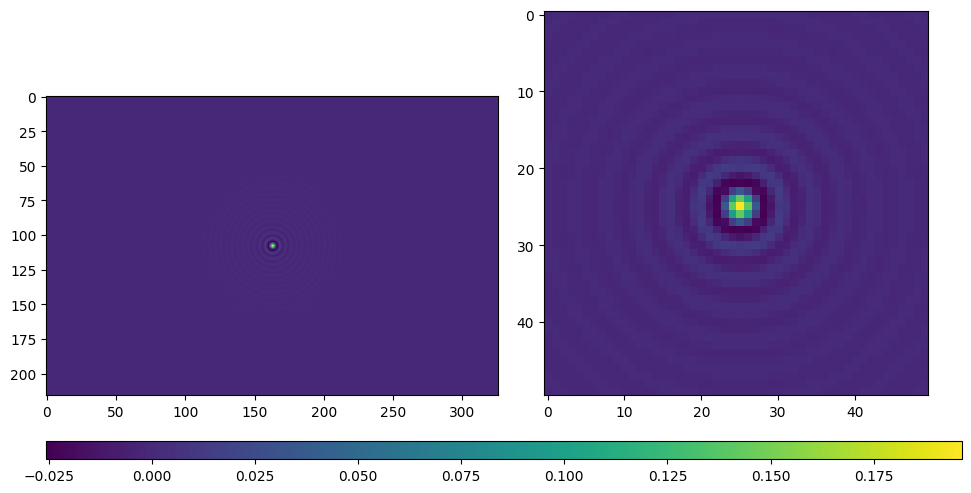

In [52]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
im = axes[0].imshow(kernel);  # imshow the whole kernel
axes[1].imshow(kernel[h//2-25:h//2+25, w//2-25:w//2+25])  # zoom in on the center
fig.colorbar(im, ax=axes, orientation='horizontal', aspect=50);

In [ ]:
# Perform convolution in *spatial* domain
# WARNING: this might take a long time (large kernel - the same size as the image)
gray_filt_ = scipy.ndimage.convolve(gray, kernel, mode='constant', cval=0.)  # notice zero padding again
gray_filt_.shape, gray_filt_.dtype, gray_filt_.min(), gray_filt_.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.10167673577182258),
 np.float64(1.0458163365340316))

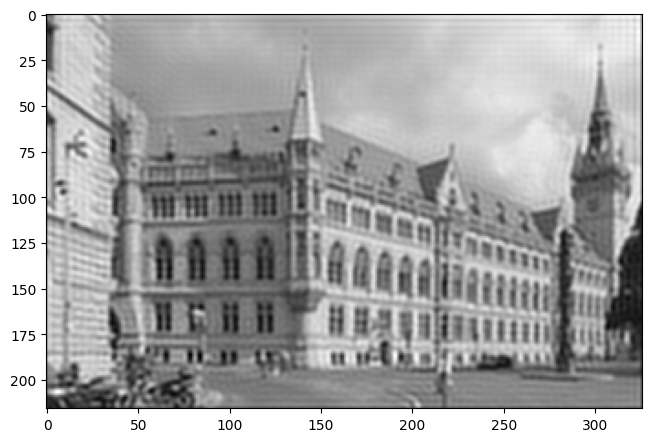

In [54]:
plt.imshow(gray_filt_, cmap='gray');

In [ ]:
np.mean(np.abs(gray_filt_ - gray_filt) / gray_filt_)  # now should be very small number

np.float64(0.003502235723006899)

- Ideally, the error above should be zero.
- In practice we see non-zero residuals that are due to numerics and rounding-off values during the process.
- Let's "imshow" absolute difference between frequency and spatial domain filtering.

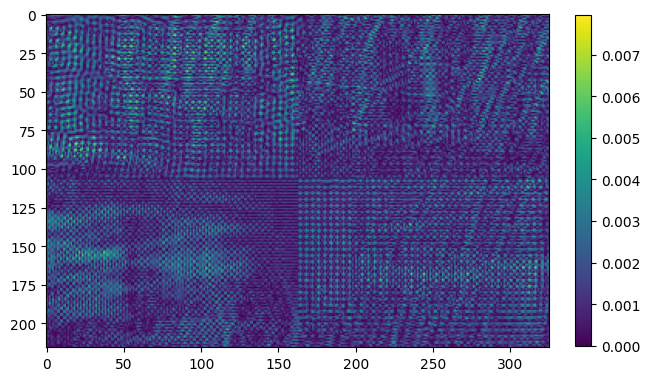

In [ ]:
plt.imshow(np.abs(gray_filt_ - gray_filt))
plt.colorbar(shrink=0.7);

- Now the error is spread out ~uniformly over the image, hinting again its due to numerics.
- To further reinforce our belief that its due to numerics, let's see what happens if we project the spatial filter $h$ back to the frequency domain.
- Remember we manually created $H$, then computed $h = \mathcal{F}^{-1}(H)$ and now we're projecting $h$ back to the frequency domain $H' = \mathcal{h}$ to see whether $H' = H$ excatly or there will be residual error.

In [ ]:
# Transform the spatial kernel back to the frequency domain
kernel_pad_dft_ = np.zeros((h_pad, w_pad))
kernel_pad_dft_[h_pad//2-h//2:h_pad//2+h//2, w_pad//2-w//2:w_pad//2+w//2] = kernel
kernel_pad_dft_ = np.roll(kernel_pad_dft_, -(w_pad // 2), axis=1)
kernel_pad_dft_ = np.roll(kernel_pad_dft_, -(h_pad // 2), axis=0)
kernel_pad_dft_ = scipy.fft.fftshift(scipy.fft.fft2(kernel_pad_dft_))
kernel_pad_dft_.shape, kernel_pad_dft_.dtype, kernel_pad_dft_.min(), kernel_pad_dft_.max()

((432, 652),
 dtype('complex128'),
 np.complex128(-0.12873559768726175-0.004040670607392667j),
 np.complex128(1.1224698340961785+1.05718252571513e-16j))

In [ ]:
# Difference from originally designed filter should be zero
np.mean(np.abs(kernel_pad_dft_ - kernel_pad_dft))

np.float64(0.005163977498791718)

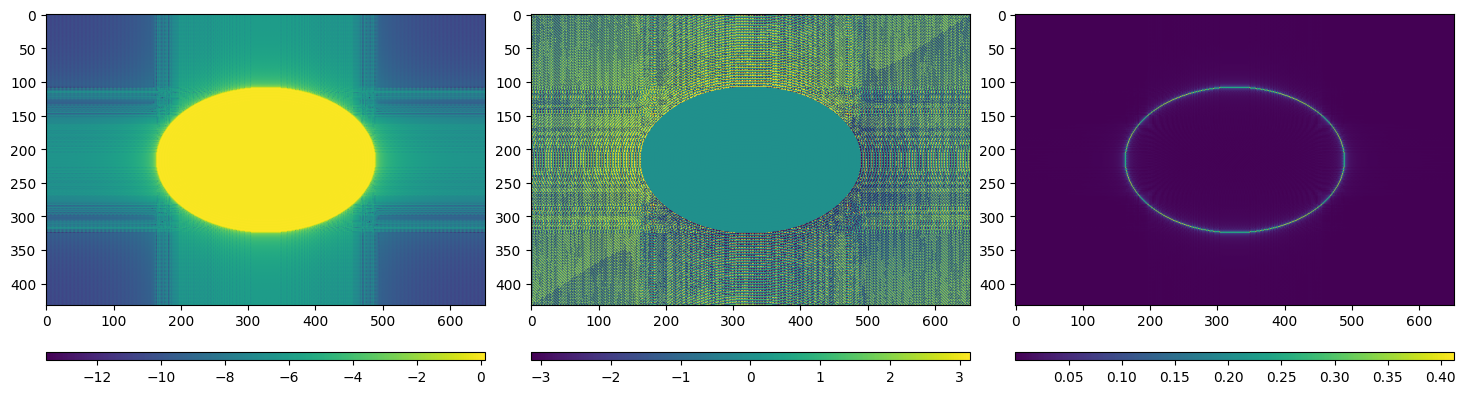

In [59]:
# Let's visualize the difference
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
im0 = axes[0].imshow(np.log(1e-6 + np.abs(kernel_pad_dft_)));
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(np.arctan2(kernel_pad_dft_.imag, kernel_pad_dft_.real));
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);
im2 = axes[2].imshow(np.abs(kernel_pad_dft_ - kernel_pad_dft));
fig.colorbar(im2, ax=axes[2], orientation='horizontal', aspect=50);

- We see that although we simply created a filter $H$ in frequency domain, the numerical imprecision and rounding-off when doing just  
  $$
  h = \mathcal{F}^{-1}(H) \\
  H' = \mathcal{F}(h)
  $$  
  causes values in $H'$ to be different than the original $H$.

## Summary

- Let's define a function for FFT-based convolution that summarizes the above steps.

In [60]:
def fftconvolve(img: np.ndarray, kernel: np.ndarray, pad_mode: str = 'constant') -> np.ndarray:
    """
    Convolve `img` with `kernel` using FFT. The result is equivalent to
    spatial convolution with zero padding (mode='constant', cval=0).
    Both `img` and `kernel` are 2D arrays.
    """
    # Input padding
    ih, iw = img.shape
    kh, kw = kernel.shape
    ph, pw = scipy.fft.next_fast_len(ih + kh - 1), scipy.fft.next_fast_len(iw + kw - 1)
    ph, pw = ph, pw
    img = np.pad(img, ((0, ph - kh), (0, pw - kw)), mode=pad_mode)
    kernel = np.pad(kernel, ((0, ph - ih), (0, pw - iw)), mode=pad_mode)
    # Filtering
    gray_dft = scipy.fft.fft2(img)
    transfer_function = scipy.fft.fft2(kernel)
    filt_dft = gray_dft * transfer_function
    filt = scipy.fft.ifft2(filt_dft).real  # notice .real
    # Center crop & return
    dp, dq = ph - ih - kh, pw - iw - kw
    return filt[ph//2-ih//2-dp//2:ph//2+ih//2-dp//2, pw//2-iw//2-dq//2:pw//2+iw//2-dq//2]

In [61]:
# Use the fftconvolve function
gray_filt_ = fftconvolve(gray, kernel)
gray_filt_.shape, gray_filt_.dtype, gray_filt_.min(), gray_filt_.max()

((216, 326),
 dtype('float64'),
 np.float64(-0.10167673577182229),
 np.float64(1.0458163365340267))

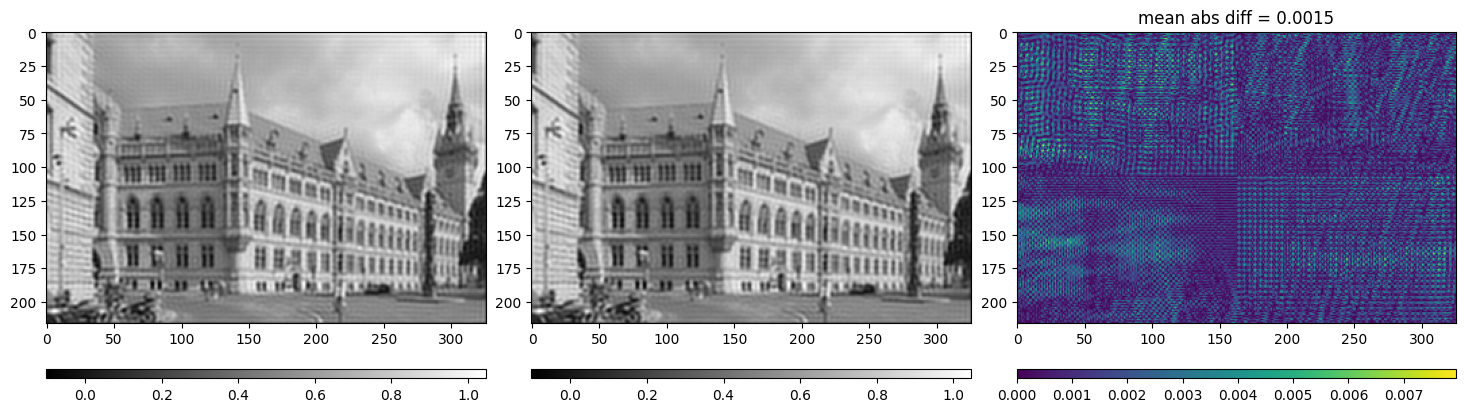

In [62]:
# Compare against spatial filtering using convolution
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.33))
im0 = axes[0].imshow(gray_filt, cmap='gray');
fig.colorbar(im0, ax=axes[0], orientation='horizontal', aspect=50);
im1 = axes[1].imshow(gray_filt_, cmap='gray');
fig.colorbar(im1, ax=axes[1], orientation='horizontal', aspect=50);
im2 = axes[2].imshow(np.abs(gray_filt_ - gray_filt));
axes[2].set_title(f"mean abs diff = {np.mean(np.abs(gray_filt_ - gray_filt)):.4f}")
fig.colorbar(im2, ax=axes[2], orientation='horizontal', aspect=50);

## Lowpass filters

**Ideal low pass filter**
- The filter we designed in the example above is called the [*ideal low pass filter (ILPF)*](https://en.wikipedia.org/wiki/Low-pass_filter#Ideal_and_real_filters), because the transition from passing band to the attenuated part of the spectrum around the cutoff frequency is maximally steep.
- However, it is definitely *not ideal* from a practical point of view due to pronounced "ringing" artifacts and its spatial footprint (size).
- In the frequency domain, the filter is
  $$
  H(m,n) = \begin{cases}
    1 & \quad \text{if} & \quad d \le d_0 \\
    0 & \quad \text{if} & \quad d \gt d_0 \\
  \end{cases}
  $$
  where
  - $d = \sqrt{\left(\frac{m}{M} - \frac{1}{2}\right)^2 + \left(\frac{n}{N} - \frac{1}{2}\right)^2}$ is the distance from origin at the center,
  - $d_0$ is the cutoff frequency, e.g. $d_0 = 0.25$ in the example above.
- There is a principle called [*Fourier uncertainty principle*](https://en.wikipedia.org/wiki/Fourier_transform#Uncertainty_principle) that says the better localized the signal is in one domain, the worse localized is in the other domain.
- E.g. because of the steepness (precise localization) of the ILPF around the cutoff frequency, its spatial kernel has long tails (is not localized very well).
- In spatial domain, the filter follows
  $$
  h(m, n) = \frac{2 d_0 \cdot J_1(2\pi \cdot d_0 \cdot d)}{d}
  $$
  where
  - $J_1$ is a first order [Bessel function](https://en.wikipedia.org/wiki/Bessel_function) of the first kind.

<figure class="image">
  <img src="../figures/frequency_domain-ideal_low_pass.png" alt="" style="width: 9.6in"/>
  <figcaption>
    Ideal low pass filter.
    Source: [Gonzalez18], Fig. 4.39
  </figcaption>
</figure>

**Gaussian low pass filter**
- In contrast to ILPF, the *Gaussian (low pass) filter (GLPF)* has very smooth transition in both frequency and spatial domain.
- In *frequency domain* it is
  $$
  H(m,n) = \exp\left({-\frac{d^2}{2d_0^2}}\right)
  $$
  where $d$ and $d_0$ are the same as above.
- In *spatial domain* it also is a 2D Gaussian function
  $$
  h(m,n) = 2\pi \cdot d_0^2 \cdot \exp\left({-2\pi^2 \cdot d_0^2 \cdot d}\right)
  $$

<figure class="image">
  <img src="../figures/frequency_domain-gaussian_low_pass.png" alt="" style="width: 9.6in"/>
  <figcaption>
    Gaussian low pass filter.
    Source: [Gonzalez18], Fig. 4.43
  </figcaption>
</figure>

- An obvious disadvantage of the GLPF is that it slightly attenuates the low frequencies too and that the transition band is wide (not precise).

**Butterworth filter**
- Something in between ILPF and GLPF is the Butteworth (low pass) filter (BLPF).
- It is designed to have the magnitude response as flat as possible in the passband.
- In the *frequency domain* it is described as
  $$
  H(k,l) = \frac{1}{1 + \left(\frac{d}{d_0}\right)^{2p}}
  $$
  where
  - $p$ is order of the filter and a hyperparameter.
- The Butterworth filter does not have a closed-form expression in the *spatial domain*.

<figure class="image">
  <img src="../figures/frequency_domain-butterworth_low_pass.png" alt="" style="width: 9.6in"/>
  <figcaption>
    Butterworth low pass filter.
    Source: [Gonzalez18], Fig. 4.45
  </figcaption>
</figure>

## Highpass filters

- Attenuating high frequencies using a lowpass filter has a blurring effect.
- Highpass filters attenuate low frequencies, and can thus be used for small detail enhancement, edge detection or image sharpening.
- We can define highpass filters as
  $$
  H_{\text{HP}}(k,l) = 1 - H_{\text{LP}}(k,l)
  $$
  where
  - $H_{\text{LP}}$ is e.g. on of the lowpass filters above (ideal, Gaussian, Butterworth).

<figure class="image">
  <img src="../figures/frequency_domain-high_pass_filters.png" alt="" style="width: 9.6in"/>
  <figcaption>
    Butterworth low pass filter.
    Source: [Gonzalez18], Fig. 4.51
  </figcaption>
</figure>

In [63]:
def normdist(shape: tuple[int, int], center_offset: tuple[float, float] = (0., 0.)) -> np.ndarray:
    h, w = shape
    m, n = np.mgrid[0:h, 0:w]
    return np.sqrt((m / h - 1 / 2 - center_offset[0]) **2 + (n / w - 1 / 2 - center_offset[1])**2)

In [64]:
def ifft2d(spectrum: np.ndarray, centered: bool = True) -> np.ndarray:
    image = scipy.fft.ifft2(scipy.fft.ifftshift(spectrum)).real
    image = scipy.fft.fftshift(image)  # np.roll
    return image

In [65]:
def logspec(img: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    return np.log(eps + np.abs(scipy.fft.fftshift(scipy.fft.fft2(img))))

In [66]:
def ideal_lowpass2d(shape: tuple[int, int], cutoff: float) -> np.ndarray:
    dist = normdist(shape)
    transfer_func = np.zeros(shape, dtype=np.complex128)
    transfer_func[dist < cutoff] = 1 + 0j
    return transfer_func

In [67]:
def gaussian_lowpass2d(shape: tuple[int, int], cutoff: float) -> np.ndarray:
    dist = normdist(shape)
    transfer_func = np.exp(-0.5 * (dist / cutoff)**2)
    return transfer_func.astype(np.complex128)

In [68]:
def butterworth_lowpass2d(shape: tuple[int, int], cutoff: float, order: int = 1, center: tuple[int, int] = (0, 0)) -> np.ndarray:
    dist = normdist(shape, center_offset=center)
    transfer_func = 1. / (1. + (dist / cutoff) ** (2 * order))
    return transfer_func.astype(np.complex128)

In [69]:
@ipywidgets.interact(
    kernel = ['ideal', 'gaussian', 'butterworth'],
    cutoff = (0., 1., 0.01),
    highpass = False,
    order = (0, 10),
)
def low_high_pass_demo(
    kernel = 'ideal',
    cutoff: float = 0.25,
    highpass: bool = False,
    order: int = 1,
) -> None:
    gray = skimage.io.imread('../data/brunswick3.jpg', as_gray=True)
    gray = skimage.transform.rescale(gray, scale=0.3)
    if kernel == 'ideal':
        transfer_func = ideal_lowpass2d(gray.shape, cutoff)
    elif kernel == 'gaussian':
        transfer_func = gaussian_lowpass2d(gray.shape, cutoff)
    elif kernel == 'butterworth':
        transfer_func = butterworth_lowpass2d(gray.shape, cutoff, order=order)
    if highpass:
        transfer_func = 1. - transfer_func
    kernel = ifft2d(transfer_func)
    filt = fftconvolve(gray, kernel)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes[0, 0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axes[0, 1].imshow(kernel)
    axes[0, 2].imshow(filt, cmap='gray')
    axes[1, 0].imshow(logspec(gray))
    axes[1, 1].imshow(logspec(kernel))
    axes[1, 2].imshow(logspec(filt))

interactive(children=(Dropdown(description='kernel', options=('ideal', 'gaussian', 'butterworth'), value='idea…

## Homomorphic filter

- [Homomorphic filters](https://en.wikipedia.org/wiki/Homomorphic_filtering) can be viewed as a sepcial case of high pass filters applied to logarithm of the input.
- Recall the illuminance-reflectance model from the [introduction](introduction.ipynb) lecture that says that images are a product
  $$
  f(m,n) = i(m,n) \cdot r(m,n)
  $$
  where
  - $i(m,n)$ is the *illumination* component
  - $r(m,n)$ is the *reflectance* component
- Illumination $i(m,n)$ corresponds to
  - the overall brightness range,
  - spatially smooth brightness changes, e.g. a result of non-uniform scene illumination,
  - and therefore to low frequencies.
- Reflectance $r(m,n)$ corresponds to
  - spatially abrupt brightnes changes, e.g. point reflections,
  - and therefore to high frequencies.
- We can *separate* both components by taking a logarithm of the illumination-reflectance equation
  $$
  \ln(f(m,n)) = \ln(i(m,n)) + \ln(r(m,n))
  $$
- Due to linearity of DFT (logarithms of) both components are separated in the frequency domain as well, i.e.
  $$
  F'(k,l) = I'(k,l) + R'(k,l)
  $$
  where $F', I', R'$ are DFT images of $\ln(f(m,n)), \ln(i(m,n)), \ln(r(m,n))$.
- Now, we can apply a **high pass** filter $H(k,l)$ to $F'(m,n)$ as
  $$
  \begin{align*}
    G'(k,l) &= H(k,l) \cdot F'(k,l) \\
            &= H(k,l) \cdot I'(k,l) + H(k,l) \cdot R'(k,l)
  \end{align*}
  $$
- The $H(k,l)$ is e.g. a scaled and shifted Gausian high pass filter, i.e.
  $$
  H(k,l) = \gamma_\text{lo} + (\gamma_\text{hi} - \gamma_\text{hi}) \cdot H_\text{GHPF}(k,l)
  $$
  where $\gamma_\text{lo}$ and $\gamma_\text{hi}$ are the attenuation and amplification hyperparameters, essentially the minimum and maximum values of $H(k,l)$.
- Using $\gamma_\text{lo} \lt 1$ and $\gamma_\text{hi} \gt 1$ will *simultaneously*
  - compress the dynamic range (low frequencies),
  - enhance contrast (high frequencies).

<figure class="image">
  <img src="../figures/frequency_domain-homomorphic_filter.png" alt="" style="width: 6.4in"/>
  <figcaption>
    Radial cross section of a homomorphic filter magnitude spectrum.
    Source: [Gonzalez18], Fig. 4.59
  </figcaption>
</figure>

In [70]:
@ipywidgets.interact(
    kernel = ['ideal', 'gaussian', 'butterworth'],
    cutoff = (0., 1., 0.01),
    order = (0, 10),
    gamma_lo = (0., 2., 0.01),
    gamma_hi = (0., 2., 0.01),
    scale = (0.1, 1.0, 0.1),
)
def homomorphic_filter_interact(
    kernel = 'gaussian',
    cutoff: float = 0.5,
    order: int = 3,
    gamma_lo: float = 0.5,
    gamma_hi: float = 1.5,
    scale: float = 0.5,
) -> None:
    gray = skimage.io.imread('../data/cave.jpg', as_gray=True)
    gray = skimage.transform.rescale(gray, scale=scale)
    gray_log = np.log(1e-6 + gray)
    if kernel == 'ideal':
        transfer_func = ideal_lowpass2d(gray.shape, cutoff)
    elif kernel == 'gaussian':
        transfer_func = gaussian_lowpass2d(gray.shape, cutoff)
    elif kernel == 'butterworth':
        transfer_func = butterworth_lowpass2d(gray.shape, cutoff, order=order)
    transfer_func = gamma_lo + (gamma_hi - gamma_lo) * (1. - transfer_func)
    kernel = ifft2d(transfer_func)
    filt_log = fftconvolve(gray_log, kernel)
    filt = np.exp(filt_log)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes[0, 0].imshow(gray, cmap='gray', vmin=0.0, vmax=1.0)
    axes[0, 1].imshow(kernel)
    axes[0, 2].imshow(filt, cmap='gray', vmin=0.0, vmax=1.0)
    axes[1, 0].imshow(logspec(gray))
    axes[1, 1].imshow(logspec(kernel))
    axes[1, 2].imshow(logspec(filt))

interactive(children=(Dropdown(description='kernel', index=1, options=('ideal', 'gaussian', 'butterworth'), va…

## Bandpass and bandreject filters

- In principle, we could combine lowpass and highpass transfer functions to attenuate arbitrary parts of the spectrum.
- A more controllable solution is to modify the expressions as
  $$
  H_\text{IBPF}(k,l) = \begin{cases}
    1 & \quad \text{if} & \quad d_0 - \frac{w}{2}\le d \le d_0 + \frac{w}{2} \\
    0 & \quad \text{if} & \quad \text{otherwise} \\
  \end{cases}
  \qquad
  H_\text{GBPF}(k,l) = \exp\left({-\frac{(d^2 - d_0^2)^2}{(d \cdot w)^2}}\right)
  \qquad
  H_\text{BBPF}(k,l) = \frac{1}{1 + \left(\frac{d^2 - d_0^2}{d \cdot w}\right)^{2p}}
  $$
  where
  - $w$ is the width of the band,
  - and other variables the same as above.

In [71]:
def ideal_bandpass2d(shape: tuple[int, int], cutoff: float, width: float) -> np.ndarray:
    dist = 1e-6 + normdist(shape)
    transfer_func = np.zeros(shape, dtype=np.complex128)
    transfer_func[np.logical_and(cutoff - width / 2 < dist, dist < cutoff + width / 2)] = 1 + 0j
    return transfer_func

In [72]:
def gaussian_bandpass2d(shape: tuple[int, int], cutoff: float, width: float) -> np.ndarray:
    dist = 1e-6 + normdist(shape)
    transfer_func = np.exp(-((dist**2 - cutoff**2) / (dist * width))**2)
    return transfer_func.astype(np.complex128)

In [73]:
def butterworth_bandpass2d(shape: tuple[int, int], cutoff: float, width: float, order: int = 1) -> np.ndarray:
    dist = 1e-6 + normdist(shape)
    transfer_func = 1. / (1. + ((dist**2 - cutoff**2) / (dist * width))**(2 * order))
    return transfer_func.astype(np.complex128)

In [74]:
@ipywidgets.interact(
    kernel = ['ideal', 'gaussian', 'butterworth'],
    cutoff = (0., 1., 0.01),
    width = (0., 1., 0.01),
    reject = False,
    order = (0, 10),
)
def band_pass_reject_demo(
    kernel = 'ideal',
    cutoff: float = 0.25,
    width: float = 0.1,
    reject: bool = False,
    order: int = 1,
) -> None:
    if kernel == 'ideal':
        transfer_func = ideal_bandpass2d(gray.shape, cutoff, width)
    elif kernel == 'gaussian':
        transfer_func = gaussian_bandpass2d(gray.shape, cutoff, width)
    elif kernel == 'butterworth':
        transfer_func = butterworth_bandpass2d(gray.shape, cutoff, width, order=order)
    if reject:
        transfer_func = 1. - transfer_func
    kernel = ifft2d(transfer_func)
    filt = fftconvolve(gray, kernel)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes[0, 0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axes[0, 1].imshow(kernel)
    axes[0, 2].imshow(filt, cmap='gray')
    axes[1, 0].imshow(logspec(gray))
    axes[1, 1].imshow(logspec(kernel))
    axes[1, 2].imshow(logspec(filt))

interactive(children=(Dropdown(description='kernel', options=('ideal', 'gaussian', 'butterworth'), value='idea…

# Linear image restoration by deconvolution

> Image restoration attempts to recover an image that has been degraded by using a priori knowledge of the degradation phenomenon.

&mdash; [Gonzalez18]

- In linear image restoration, we consider degradations that can be modeled as a convolution
  $$
  g(m,n) = h(m,n) * f(m,n) + z(m,n)
  $$
  where
  - $f(m,n)$ is the original but unobserved image,
  - $h(m,n)$ is the impulse response of the degradation function, so called [**point spread function (PSF)**](https://en.wikipedia.org/wiki/Point_spread_function),
  - $g(m,n)$ is the observed degraded image,
  - $z(m,n)$ is random additive noise.
- The goal is to restore $f(m,n)$ from the above model when knowing something about $h(m,n)$ and $z(m,n)$.
- Since $g(m,n)$ is a result of convolution, we can call the process of restoring $f(m,n)$ [**deconvolution**](https://en.wikipedia.org/wiki/Deconvolution).
- In this lecture, we'll only consider techniques that simplify the restoration by transforming the model into the frequency domain, i.e.
  $$
  G(k,l) = H(k,l) \cdot F(k,l) + Z(k,l)
  $$
- If we knew $H(k,l)$ and $Z(k,l)$ exactly, restoration of $F(k,l)$ would be straightforward.
- Usually, however, we don't have access to the degradation function $\rightarrow$ we assume or estimate it.

## Degradations that can be modeled

- **Wrong lens focus**
  $$
  H(k,l) = \frac{J_1(a \cdot d)}{a \cdot d}
  $$
- **Linear motion of camera**
  $$
    H(k,l) = \frac{\sin(\pi \cdot \tau \cdot v)}{\pi \cdot v} \cdot e^{-\text{i}\cdot\pi\cdot v}
           = \tau \cdot \text{sinc}(\pi \cdot \tau \cdot v) \cdot e^{-\text{i}\cdot\pi\cdot v}
  $$
  where
  - $v = (v_k \cdot k + v_l \cdot l)$ is the velocity of the movement,
  - $\tau$ is the exposure time.
- **Atmospheric turbulence**
  $$
  H(k,l) = \exp(-\alpha \cdot d^{2\gamma})
  $$
  where
  - $\alpha$ is a constant that depends on the nature of the turbulence and is usually found experimentally,
  - $\gamma = 5/6$, but sometimes $\gamma = 1$ is used (in which case reduces to Gaussian blur).

In [75]:
def linear_motion(shape: tuple[int, int], vel_k: float, vel_l: float, exp_time: float) -> np.ndarray:
    h, w = shape
    k, l = np.mgrid[0:h, 0:w]
    velocity = vel_k * (k / h - 0.5) + vel_l * (l / w - 0.5)
    return exp_time * np.sinc(exp_time * velocity) * np.exp(-1j * np.pi * velocity)

In [76]:
@ipywidgets.interact(
    image = os.listdir('../data'),
    # kernel = ['linear_motion', 'gaussian', 'butterworth'],
    velocity_k = (0., 10., 0.1),
    velocity_l = (0., 10., 0.1),
    exposure_time = (0., 10., 0.1),
)
def degradation_interact(
    image: str = 'license_plate.jpg',
    # kernel = 'linear_motion',
    velocity_k: float = 1.,
    velocity_l: float = 4.,
    exposure_time: float = 2.,
) -> None:
    gray = skimage.io.imread('../data/' + image, as_gray=True)
    scale = 320. / max(gray.shape)
    gray = skimage.transform.rescale(gray, scale)
    # gray = skimage.util.img_as_float(gray)
    # if kernel == 'linear_motion':
    transfer_func = linear_motion(gray.shape, velocity_k, velocity_l, exposure_time)
    # elif kernel == 'gaussian':
    #     transfer_func = gaussian_bandpass2d(gray.shape, cutoff, width)
    # elif kernel == 'butterworth':
    #     transfer_func = butterworth_bandpass2d(gray.shape, cutoff, width, order=order)
    kernel = ifft2d(transfer_func)
    degraded = fftconvolve(gray, kernel)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes[0, 0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axes[0, 1].imshow(kernel)
    axes[0, 2].imshow(degraded, cmap='gray')
    axes[1, 0].imshow(logspec(gray))
    axes[1, 1].imshow(logspec(kernel))
    axes[1, 2].imshow(logspec(degraded))

interactive(children=(Dropdown(description='image', index=13, options=('alien.png', 'brunswick3.jpg', 'buzz_al…

## Inverse filtering

- Directly solving for $F$ in the frequency domain degradation model yields
  $$
  \hat{F}(k,l) = \frac{G(k,l) - Z(k,l)}{H(k,l)}
  $$
- Two problems however
  1. All of the coefficients in $H(k,l)$ must be non-zero.  
     Otherwise the result will have undefined values. Even dividing by small values will amplify numerical noise.
  2. This will only work well when we can neglect the noise $Z(k,l)$, because we don't actually know it in practice.  
     Magnitude spectrum of the noise is typically wider than degradation $\rightarrow$ high frequencies will be divided by small number (amplified) $\rightarrow $ another source of noise.

In [77]:
def inverse_filter(gray_degr: np.ndarray, kernel_degr: np.ndarray, max_ratio: float = 5.) -> np.ndarray:
    gray_degr_dft = scipy.fft.fftshift(scipy.fft.fft2(gray_degr))
    kernel_degr_dft = scipy.fft.fftshift(scipy.fft.fft2(kernel_degr))
    gray_r_dft = gray_degr_dft / kernel_degr_dft
    ratio = np.abs(gray_r_dft) / np.abs(gray_degr_dft)
    too_high = ratio > max_ratio
    gray_r_dft[too_high] *= max_ratio / ratio[too_high]
    gray_r = ifft2d(gray_r_dft)
    return gray_r

In [78]:
@ipywidgets.interact(
    image = os.listdir('../data'),
    kernel = ['linear_motion', 'gaussian', 'butterworth'],
    velocity_k = (0., 10., 0.1),
    velocity_l = (0., 10., 0.1),
    exposure_time = (0., 10., 0.1),
    noise_std = (0., 1., 0.01),
    max_ratio = (1., 100., 1.),
)
def invesre_filter_interact(
    image: str = 'dog.jpg',
    kernel = 'linear_motion',
    velocity_k: float = 1.,
    velocity_l: float = 4.,
    exposure_time: float = 2.,
    noise_std: float = 0.,
    max_ratio: float = 5.,
) -> None:
    gray = skimage.io.imread('../data/' + image, as_gray=True)[:-5]
    scale = 0.5  # 320. / max(gray.shape)
    gray = skimage.transform.rescale(gray, scale)
    if kernel == 'linear_motion':
        transfer_func = linear_motion(gray.shape, velocity_k, velocity_l, exposure_time)
    kernel = ifft2d(transfer_func)
    degraded = fftconvolve(gray, kernel)
    degraded += noise_std * np.random.randn(*degraded.shape)
    restored = inverse_filter(degraded, kernel, max_ratio=max_ratio)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    for i, img in enumerate((gray, degraded, restored)):
        im = axes[0, i].imshow(img, cmap='gray')
        fig.colorbar(im, ax=axes[0, i], orientation='horizontal')
        im = axes[1, i].imshow(logspec(img))
        fig.colorbar(im, ax=axes[1, i], orientation='horizontal')

interactive(children=(Dropdown(description='image', index=8, options=('alien.png', 'brunswick3.jpg', 'buzz_ald…

## Wiener filter (minimum mean square error filter)

- [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) tries to find the estimate $\hat{f}$ the original unobserved image $f$ by minimizing (least squares)
  $$
  e^2 = \text{E}[(f - \hat{f})^2]
  $$
  where
  - $\text{E}[\cdot]$ denotes the expected value of the argument.
- On contrast to the inverse filter, it explicitly models noise.
- It assumes that [Gonzalez]
  - noise and the image are uncorrelated,
  - noise or image have zero mean,
  - values of the estimate $\hat{f}(m,n)$ is a linear function of the *degraded* image values $g(m,n)$.
- In *frequency domain*, it can be derived as
  $$
  \hat{F}(k,l) = \frac{H^\ast(k,l)}{|H(k,l)|^2 + |Z(k,l)|^2/|F(k,l)|^2} \cdot G(k,l)
  $$
  where
  - $|Z(k,l)|^2 = Z(k,l) \cdot Z^\ast(k,l)$ is the power spectrum (autocorrelation) of the *noise*,
  - $|F(k,l)|^2 = F(k,l) \cdot F^\ast(k,l)$ is the power spectrum (autocorrelation) of the *original undegraded image*.
- Since we usually do not know $|F(k,l)|^2$, the filter is often approximated as
  $$
  \hat{F}(k,l) = \frac{H^\ast(k,l)}{|H(k,l)|^2 + \kappa} \cdot G(k,l)
  $$
  where
  - $\kappa$ is a hyperparameter and can be determined empirically.

In [79]:
def wiener_filter(
    gray_degr: np.ndarray,
    kernel_degr: np.ndarray,
    noise_to_image_powspec: Union[float, np.ndarray] = 0.,
    max_ratio: float = 5.0,
) -> np.ndarray:
    gray_degr_dft = scipy.fft.fftshift(scipy.fft.fft2(gray_degr))
    kernel_degr_dft = scipy.fft.fftshift(scipy.fft.fft2(kernel_degr))
    kernel_powspec = np.abs(kernel_degr_dft) ** 2
    gray_r_dft = kernel_degr_dft.conj() / (kernel_powspec + noise_to_image_powspec) * gray_degr_dft
    ratio = np.abs(gray_r_dft) / np.abs(gray_degr_dft)
    too_high = ratio > max_ratio
    gray_r_dft[too_high] *= max_ratio / ratio[too_high]
    gray_r = ifft2d(gray_r_dft)
    return gray_r

In [80]:
@ipywidgets.interact(
    image=os.listdir('../data'),
    kernel=['linear_motion', 'gaussian', 'butterworth'],
    velocity_k=(0.0, 10.0, 0.1),
    velocity_l=(0.0, 10.0, 0.1),
    exposure_time=(0.0, 10.0, 0.1),
    noise_std=(0.0, 1.0, 0.01),
    max_ratio=(1.0, 100.0, 1.0),
    noise_to_image_powspec=(-0.01, 1.0, 0.01),
)
def degradation_interact(
    image: str = 'license_plate.jpg',
    kernel='linear_motion',
    velocity_k: float = 1.0,
    velocity_l: float = 4.0,
    exposure_time: float = 2.0,
    noise_std: float = 0.0,
    max_ratio: float = 5.0,
    noise_to_image_powspec: float = 1.0,
) -> None:
    gray = skimage.io.imread('../data/' + image, as_gray=True)[:-5]
    scale = 0.5  # 320. / max(gray.shape)
    gray = skimage.transform.rescale(gray, scale)
    if kernel == 'linear_motion':
        transfer_func = linear_motion(gray.shape, velocity_k, velocity_l, exposure_time)
    kernel = ifft2d(transfer_func)
    degraded = fftconvolve(gray, kernel)
    noise = noise_std * np.random.randn(*degraded.shape)
    degraded += noise
    noise_powspec = np.abs(scipy.fft.fftshift(scipy.fft.fft2(noise))) ** 2
    gray_powspec = np.abs(scipy.fft.fftshift(scipy.fft.fft2(gray))) ** 2
    if noise_to_image_powspec < 0.0:
        noise_to_image_powspec = noise_powspec / gray_powspec
    restored = wiener_filter(degraded, kernel, noise_to_image_powspec=noise_to_image_powspec, max_ratio=max_ratio)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    for i, img in enumerate((gray, degraded, restored)):
        im = axes[0, i].imshow(img, cmap='gray')
        fig.colorbar(im, ax=axes[0, i], orientation='horizontal')
        im = axes[1, i].imshow(logspec(img))
        fig.colorbar(im, ax=axes[1, i], orientation='horizontal')

interactive(children=(Dropdown(description='image', index=13, options=('alien.png', 'brunswick3.jpg', 'buzz_al…

# Compression

## Discrete cosine transform

## JPEG